In [1]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [2]:
!pip install lightGBM

In [3]:
import gc
gc.collect()

214

In [4]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm

In [5]:
inference_page_id = 2025060201

is_denso = False
# train_year_list = ["2024"]
train_year_list = ["2023", "2024"]
train_data = pd.DataFrame()
horse_past_data = pd.DataFrame()
horse_peds_data = pd.DataFrame()
jockey_past_data = pd.DataFrame()
for year in train_year_list:
    train_path = '/home/hayato/horse_inference/data_for_train/train_data/' + year + '/'
    if is_denso:
        train_path = '/home/denso/horse_inference/data_for_train/train_data/' + year + '/'
    # train dataに各年の学習データを縦方向に結合
    train_data = pd.concat([train_data, pd.read_csv(train_path + "train_data_results_" + year + ".csv", encoding='utf-8')], axis=0)
    print("train data length {}".format(len(train_data)))

    # 勝率データ、過去のデータを取得
    horse_past_data = pd.concat([horse_past_data, pd.read_csv(train_path + 'horse_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_past_data length {}".format(len(horse_past_data)))
    horse_peds_data = pd.concat([horse_peds_data, pd.read_csv(train_path + 'horse_born_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_peds_data length {}".format(len(horse_peds_data)))
    # ジョッキーの過去データを取得
    jockey_past_data = pd.concat([jockey_past_data, pd.read_csv(train_path + 'jockey_results_' + year + '.csv', encoding='utf-8')], axis=0)
    # jockeyデータはデータの中で"累計"が含まれているものだけを抽出
    # "年度"列が"累計"の行だけを抽出
    jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']
    print("jockey_past_data length {}".format(len(jockey_past_data)))

train data length 9371
horse_past_data length 99871
horse_peds_data length 4870
jockey_past_data length 161
train data length 54954
horse_past_data length 240812
horse_peds_data length 6463
jockey_past_data length 360


In [6]:
# horse_past_dataから最初のhorse_idの情報だけを抽出
first_horse_past_data = horse_past_data.drop_duplicates(subset='horse_id', keep='first')
# train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')

# train dataに対してhorse_past_data、horse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, first_horse_past_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54954 entries, 0 to 54953
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            54954 non-null  object 
 1   枠番            54954 non-null  int64  
 2   馬番            54954 non-null  int64  
 3   馬名            54954 non-null  object 
 4   性齢            54954 non-null  object 
 5   斤量            54954 non-null  float64
 6   騎手_x          54954 non-null  object 
 7   タイム_x         54450 non-null  object 
 8   着差_x          50420 non-null  object 
 9   単勝            54954 non-null  object 
 10  人気            54728 non-null  float64
 11  馬体重_x         54954 non-null  object 
 12  調教師           54954 non-null  object 
 13  course_len    54954 non-null  int64  
 14  weather       54954 non-null  object 
 15  race_type     54954 non-null  object 
 16  ground_state  54954 non-null  object 
 17  date          54954 non-null  object 
 18  horse_id      54954 non-nu

In [7]:
# horse_peds_dataはpeds62がhorse_idなので、peds62をhorse_idに変更
horse_peds_data = horse_peds_data.rename(columns={'peds_62': 'horse_id'})
# すごい馬の血糖情報があるけどそんなにいらないので、5頭分のpeds0からpeds5までの情報だけを取得
horse_peds_data = horse_peds_data[['horse_id', 'peds_0', 'peds_1', 'peds_2', 'peds_3', 'peds_4', 'peds_5']]
# 1pedsに色んな情報が入っているので、半角スペースまでの情報だけを取得
horse_peds_data['peds_0'] = horse_peds_data['peds_0'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_1'] = horse_peds_data['peds_1'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_2'] = horse_peds_data['peds_2'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_3'] = horse_peds_data['peds_3'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_4'] = horse_peds_data['peds_4'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_5'] = horse_peds_data['peds_5'].apply(lambda x: x.split(' ')[0])
# train dataに対してhorse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59786 entries, 0 to 59785
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            59786 non-null  object 
 1   枠番            59786 non-null  int64  
 2   馬番            59786 non-null  int64  
 3   馬名            59786 non-null  object 
 4   性齢            59786 non-null  object 
 5   斤量            59786 non-null  float64
 6   騎手_x          59786 non-null  object 
 7   タイム_x         59254 non-null  object 
 8   着差_x          54866 non-null  object 
 9   単勝            59786 non-null  object 
 10  人気            59541 non-null  float64
 11  馬体重_x         59786 non-null  object 
 12  調教師           59786 non-null  object 
 13  course_len    59786 non-null  int64  
 14  weather       59786 non-null  object 
 15  race_type     59786 non-null  object 
 16  ground_state  59786 non-null  object 
 17  date          59786 non-null  object 
 18  horse_id      59786 non-nu

In [8]:
# train_dataに対してjockey_past_dataをjockey_idをキーにして結合
# jockey_resultsから必要なjockey_idの情報だけを抽出
jockey_info = jockey_past_data[jockey_past_data['jockey_id'].isin(train_data['jockey_id'])]

train_data = pd.merge(train_data, jockey_info, on='jockey_id', how='left')
# train_data = pd.merge(train_data, jockey_past_data, on='jockey_id', how='left')
print(train_data.info())
# テスト的にtrain_dataのデータをcsvに保存
train_data.to_csv(train_path + "train_data_check.csv", index=False, encoding='utf-8')
print("train_data lenght :{}".format(len(train_data)))
train_data.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115612 entries, 0 to 115611
Data columns (total 66 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   着順            115612 non-null  object 
 1   枠番            115612 non-null  int64  
 2   馬番            115612 non-null  int64  
 3   馬名            115612 non-null  object 
 4   性齢            115612 non-null  object 
 5   斤量            115612 non-null  float64
 6   騎手_x          115612 non-null  object 
 7   タイム_x         114572 non-null  object 
 8   着差_x          106063 non-null  object 
 9   単勝            115612 non-null  object 
 10  人気            115129 non-null  float64
 11  馬体重_x         115612 non-null  object 
 12  調教師           115612 non-null  object 
 13  course_len    115612 non-null  int64  
 14  weather       115612 non-null  object 
 15  race_type     115612 non-null  object 
 16  ground_state  115612 non-null  object 
 17  date          115612 non-null  object 
 18  hors

,枠番,馬番,斤量,人気,course_len,horse_id,jockey_id,race_id,R,映 像,...,厩舎 ｺﾒﾝﾄ,備考,賞金,1着,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利
count,115612.000000,115612.000000,115612.000000,115129.000000,115612.000000,1.156120e+05,115612.000000,1.156120e+05,115460.000000,0.0,...,0.0,0.0,37584.000000,115612.000000,115612.000000,115612.000000,115612.000000,115612.000000,115612.000000,115612.000000
mean,4.775983,7.594506,55.689362,7.525020,1650.709701,2.020279e+09,1403.631466,2.023871e+11,7.584159,NaN,...,NaN,NaN,409.074681,580.429082,567.362315,555.077898,5343.239992,7046.109288,314.422032,23.990624
std,2.268009,4.349898,1.848544,4.318974,422.395577,1.324261e+06,1090.546787,3.996769e+07,3.286177,NaN,...,NaN,NaN,1259.910558,722.626662,618.853819,556.567614,4280.495678,5941.315530,401.799186,50.947331
min,1.000000,1.000000,49.000000,1.000000,1000.000000,2.012101e+09,422.000000,2.023010e+11,1.000000,NaN,...,NaN,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,3.000000,4.000000,55.000000,4.000000,1200.000000,2.019106e+09,1096.000000,2.024020e+11,5.000000,NaN,...,NaN,NaN,40.000000,108.000000,118.000000,130.000000,1882.000000,2199.000000,29.000000,0.000000
50%,5.000000,7.000000,56.000000,7.000000,1700.000000,2.020109e+09,1160.000000,2.024050e+11,8.000000,NaN,...,NaN,NaN,130.000000,312.000000,345.000000,364.000000,3856.000000,4790.000000,169.000000,7.000000
75%,7.000000,11.000000,57.000000,11.000000,1800.000000,2.021105e+09,1187.000000,2.024080e+11,10.000000,NaN,...,NaN,NaN,400.000000,803.000000,850.000000,910.000000,8772.000000,11616.000000,468.000000,23.000000
max,8.000000,18.000000,65.000000,18.000000,4250.000000,2.022110e+09,5667.000000,2.024100e+11,12.000000,NaN,...,NaN,NaN,50340.200000,4559.000000,3451.000000,2772.000000,18808.000000,24936.000000,2047.000000,363.000000


In [9]:
# train_dataの重複をrace_id, horse_idで削除
train_data = train_data.drop_duplicates(subset=["race_id", "horse_id"], keep='first')
# 重複をassertで確認
assert train_data.duplicated(subset=["race_id", "horse_id"]).sum() == 0

# oddsだけ前処理の前に準備しておく
train_data['単勝'] = train_data['単勝'].replace('---', 100)
train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))   
train_data_for_ranking = train_data.copy()


In [10]:

inference_data_path = "/home/hayato/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"
if is_denso:
    inference_data_path = "/home/denso/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"

In [11]:
train_data.info()
train_data_mlp = train_data.copy()


<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 115610
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            54954 non-null  object 
 1   枠番            54954 non-null  int64  
 2   馬番            54954 non-null  int64  
 3   馬名            54954 non-null  object 
 4   性齢            54954 non-null  object 
 5   斤量            54954 non-null  float64
 6   騎手_x          54954 non-null  object 
 7   タイム_x         54450 non-null  object 
 8   着差_x          50420 non-null  object 
 9   単勝            54954 non-null  object 
 10  人気            54728 non-null  float64
 11  馬体重_x         54954 non-null  object 
 12  調教師           54954 non-null  object 
 13  course_len    54954 non-null  int64  
 14  weather       54954 non-null  object 
 15  race_type     54954 non-null  object 
 16  ground_state  54954 non-null  object 
 17  date          54954 non-null  object 
 18  horse_id      54954 non-null  

In [12]:
from utils.utils import *

train_data = preprocess(train_data)
# mlp用にコピーする
train_data_mlp = preprocess(train_data_mlp, is_mlp=True)   


['A.' 'Abba' 'Abbatiale' ... 'ヴェルヴェットクイーン' 'ヴォークリンデ' nan]
<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 115610
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         54954 non-null  int64  
 1   condition        54954 non-null  int64  
 2   umaban           54954 non-null  int64  
 3   horse_age        54954 non-null  int64  
 4   horse_sex        54954 non-null  int64  
 5   handi            54954 non-null  int64  
 6   odds_inv         54954 non-null  float64
 7   weather          54954 non-null  int64  
 8   ground_state     54954 non-null  int64  
 9   天気               54954 non-null  int64  
 10  頭 数              54947 non-null  float64
 11  枠番               54954 non-null  int64  
 12  馬番               54954 non-null  int64  
 13  1/オ ッ ズ          54425 non-null  float64
 14  人気               54728 non-null  float64
 15  斤量               54954 non-null  float64
 16  距離  

In [13]:
# レースごとのオッズの特長量変換
# 追加する特長量
# log_odds: オッズの対数
# normalized_odds: オッズの正規化
# zscore_odds: オッズのzscore
# odds_rank: オッズの順位
# odds_std: オッズの標準偏差
train_data_for_ranking = odds_feature_engineering(train_data_for_ranking)


In [14]:
# 各レースごとにオッズをソートして1位、2位、3位のオッズを取得
# オッズの差分を計算して新しい特徴量として追加
odds_diff_1_2, odds_diff_1_3 = get_odds_differences(train_data_for_ranking)
train_data_for_ranking['odds_diff-1-2'] = odds_diff_1_2
train_data_for_ranking['odds_diff-1-3'] = odds_diff_1_3

# 結果を確認
# print(train_data_for_ranking[['race_id', 'odds', 'odds_diff_1_2', 'odds_diff_1_3']].head())

In [15]:
# ランキング学習での推論
# step1 クエリを作成する
# ランキング学習のためのクエリを作成

# ============データ情報整理================
# X_train: 学習用データ。クエリ必要
# X_valid: 検証データ。クエリ必要
# y_train: 学習用データの答え
# y_valid: 検証データの答え
# test_total: テストデータ。クエリ不要
# y_test_true: テストデータの答え
# ========================================
# ランキング学習用のtrain dataを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_data_for_ranking[:int(len(train_data_for_ranking)*0.7)]
test_ranking = train_data_for_ranking[int(len(train_data_for_ranking)*0.7):]
test_ranking_race_id = test_ranking["race_id"]
# train_rankingを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_ranking[:int(len(train_ranking)*0.7)]
valid_ranking = train_ranking[int(len(train_ranking)*0.7):]

# trainデータのクエリを作成
train_query, sorted_train_data = create_query(train_ranking,"train")
# validデータのクエリを作成
valid_query, sorted_valid_data = create_query(valid_ranking,"valid")





Resulting list of horse counts per race (sorted by date):
[8, 12, 14, 13, 10, 14, 16, 13, 9, 9, 15, 14, 8, 14, 16, 14, 6, 16, 12, 11, 10, 14, 16, 14, 9, 14, 15, 14, 14, 12, 15, 13, 14, 8, 16, 11, 14, 12, 14, 16, 12, 13, 13, 12, 14, 14, 14, 14, 14, 12, 16, 14, 10, 16, 13, 13, 9, 14, 14, 14, 14, 14, 15, 14, 7, 14, 12, 14, 11, 11, 14, 16, 9, 14, 12, 14, 13, 16, 12, 13, 9, 11, 14, 16, 7, 12, 14, 14, 10, 14, 14, 8, 11, 9, 15, 13, 12, 14, 16, 14, 11, 14, 16, 14, 14, 16, 14, 12, 11, 12, 13, 14, 9, 12, 16, 9, 14, 14, 15, 13, 11, 5, 12, 14, 13, 14, 14, 14, 14, 14, 14, 14, 9, 14, 12, 14, 5, 16, 12, 14, 16, 14, 16, 14, 8, 14, 16, 14, 13, 12, 16, 14, 16, 14, 10, 14, 11, 9, 14, 16, 14, 16, 14, 14, 14, 12, 14, 14, 16, 14, 12, 16, 11, 14, 9, 11, 8, 13, 13, 12, 16, 14, 12, 16, 11, 16, 11, 11, 16, 14, 16, 12, 16, 14, 11, 12, 14, 12, 14, 12, 11, 9, 15, 14, 14, 16, 12, 13, 11, 13, 12, 16, 11, 13, 16, 15, 10, 10, 16, 11, 5, 11, 11, 13, 8, 13, 16, 12, 16, 9, 12, 14, 6, 10, 9, 14, 13, 13, 13, 13, 9, 12, 12

In [16]:
# クエリの数の合計を確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
print("Total number of queries: {}".format(len(train_query) + len(valid_query)))
print("Number of rows in train data: {}".format(len(sorted_train_data)))
print("Number of rows in valid data: {}".format(len(sorted_valid_data)))
print("Total number of rows: {}".format(len(sorted_train_data) + len(sorted_valid_data)))


Number of queries in train data: 26926
Number of queries in valid data: 8078
Total number of queries: 2566
Number of rows in train data: 26926
Number of rows in valid data: 8078
Total number of rows: 35004


In [17]:
# クエリを取得したので前処理をかける
X_sorted_train_data = preprocess(sorted_train_data,is_ranking=True, is_mlp=True)
X_sorted_valid_data = preprocess(sorted_valid_data,is_ranking=True, is_mlp=True)
test_ranking = preprocess(test_ranking,is_ranking=True, is_mlp=True)

['A.' 'Abba' 'Abbatiale' ... 'ヴェルヴェットクイーン' 'ヴォークリンデ' nan]
<class 'pandas.core.frame.DataFrame'>
Index: 26926 entries, 0 to 58687
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   distance             26926 non-null  int64  
 1   condition            26926 non-null  int64  
 2   umaban               26926 non-null  int64  
 3   horse_age            26926 non-null  int64  
 4   horse_sex            26926 non-null  int64  
 5   handi                26926 non-null  int64  
 6   odds_inv             26926 non-null  float64
 7   weather              26926 non-null  int64  
 8   ground_state         26926 non-null  int64  
 9   天気                   26926 non-null  int64  
 10  頭 数                  26923 non-null  float64
 11  枠番                   26926 non-null  int64  
 12  馬番                   26926 non-null  int64  
 13  1/オ ッ ズ              26626 non-null  float64
 14  人気                   26818 non-nu

/home/hayato/horse_inference/scripts/utils/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['着順'] = train_data['着順'].replace('除', 100).replace('中', 100).replace('取', 100).replace('計不', 100)
/home/hayato/horse_inference/scripts/utils/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['着順'] = train_data['着順'].replace('計不', 100)
/home/hayato/horse_inference/scripts/utils/utils.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

['Abba' 'Absolute' 'Acadiana' ... 'ヴェルザンディ' 'ヴォークリンデ' nan]
<class 'pandas.core.frame.DataFrame'>
Index: 16487 entries, 82132 to 115610
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   distance             16487 non-null  int64  
 1   condition            16487 non-null  int64  
 2   umaban               16487 non-null  int64  
 3   horse_age            16487 non-null  int64  
 4   horse_sex            16487 non-null  int64  
 5   handi                16487 non-null  int64  
 6   odds_inv             16487 non-null  float64
 7   weather              16487 non-null  int64  
 8   ground_state         16487 non-null  int64  
 9   天気                   16487 non-null  int64  
 10  頭 数                  16485 non-null  float64
 11  枠番                   16487 non-null  int64  
 12  馬番                   16487 non-null  int64  
 13  1/オ ッ ズ              16358 non-null  float64
 14  人気                   16416 

In [18]:
# スクレイピングするごとにカラム名が変化してくので、カラム名のスペースを削除する処理を学習前に追加
# X_sorted_train_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace(' ', '')
X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace('　', '')

# X_sorted_valid_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_valid_data.columns = X_sorted_valid_data.columns.str.replace(' ', '')
X_sorted_valid_data.columns = X_sorted_valid_data.columns.str.replace('　', '')

# test_ranking.columnsの日本語文字列の半角、全角スペースを削除する
test_ranking.columns = test_ranking.columns.str.replace(' ', '')
test_ranking.columns = test_ranking.columns.str.replace('　', '')

In [19]:
# 2位以下の予測のため学習データをコピーしておく
X_sorted_train_data_copy = X_sorted_train_data.copy()
X_sorted_valid_data_copy = X_sorted_valid_data.copy()
test_ranking_copy = test_ranking.copy()



In [20]:
# うまく目的変数の変換ができないので、現状のデータを見てみる
# X_sorted_train_data.to_csv("X_sorted_train_data.csv", index=False)

In [21]:
# X_sorted_train_dataにgoal_number_replaceを追加してcsvに保存する
# X_sorted_train_data.to_csv("X_sorted_train_data_add_goal_number.csv", index=False)

In [22]:
# 1. 目的変数goal_number_replaceを確保
# 2. 実際のgoal_numberを確保
# 3. goal_number_replaceを削除
# 4. goal_numberを削除
# 1========================================================
y_train_ranking = X_sorted_train_data['goal_number_replace']
y_valid_ranking = X_sorted_valid_data['goal_number_replace']
y_test_true_ranking = test_ranking['goal_number_replace']
# 2========================================================
y_train_ranking_goal = X_sorted_train_data['goal_number']
y_valid_ranking_goal = X_sorted_valid_data['goal_number']
y_test_true_ranking_goal = test_ranking['goal_number']
# 3========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number', axis=1)
test_ranking = test_ranking.drop('goal_number', axis=1)
# 4========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number_replace', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number_replace', axis=1)
test_ranking = test_ranking.drop('goal_number_replace', axis=1)
# 5========================================================
X_sorted_train_data = X_sorted_train_data.drop('race_id', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('race_id', axis=1)
test_ranking = test_ranking.drop('race_id', axis=1)

In [23]:
# 学習データ
X_sorted_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26926 entries, 0 to 58687
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         26926 non-null  int64  
 1   condition        26926 non-null  int64  
 2   umaban           26926 non-null  int64  
 3   horse_age        26926 non-null  int64  
 4   horse_sex        26926 non-null  int64  
 5   handi            26926 non-null  int64  
 6   odds_inv         26926 non-null  float64
 7   weather          26926 non-null  int64  
 8   ground_state     26926 non-null  int64  
 9   天気               26926 non-null  int64  
 10  頭数               26923 non-null  float64
 11  枠番               26926 non-null  int64  
 12  馬番               26926 non-null  int64  
 13  1/オッズ            26626 non-null  float64
 14  人気               26818 non-null  float64
 15  斤量               26926 non-null  float64
 16  距離               26926 non-null  int64  
 17  馬場               

In [24]:
test_ranking.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16487 entries, 82132 to 115610
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         16487 non-null  int64  
 1   condition        16487 non-null  int64  
 2   umaban           16487 non-null  int64  
 3   horse_age        16487 non-null  int64  
 4   horse_sex        16487 non-null  int64  
 5   handi            16487 non-null  int64  
 6   odds_inv         16487 non-null  float64
 7   weather          16487 non-null  int64  
 8   ground_state     16487 non-null  int64  
 9   天気               16487 non-null  int64  
 10  頭数               16485 non-null  float64
 11  枠番               16487 non-null  int64  
 12  馬番               16487 non-null  int64  
 13  1/オッズ            16358 non-null  float64
 14  人気               16416 non-null  float64
 15  斤量               16487 non-null  float64
 16  距離               16487 non-null  int64  
 17  馬場          

In [25]:
# クエリの合計とデータの合計が一致しているか確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
# y_train_rankingの数とX_sorted_train_dataの数が一致しているか確認
print("y_train_ranking length {}".format(len(y_train_ranking)))
print("Number of rows in train data: {}".format(len(X_sorted_train_data)))
print("Number of rows in valid data: {}".format(len(X_sorted_valid_data)))
print("Total number of rows: {}".format(len(X_sorted_train_data) + len(X_sorted_valid_data)))

Number of queries in train data: 26926
Number of queries in valid data: 8078
y_train_ranking length 26926
Number of rows in train data: 26926
Number of rows in valid data: 8078
Total number of rows: 35004


In [26]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.metrics import ndcg_score

# データの準備
# X_sorted_train_data, y_train_ranking, train_query
# X_sorted_valid_data, y_valid_ranking, valid_query

# ランキング学習
model = lgb.LGBMRanker(
    random_state=42,
    objective='lambdarank',
    metric='ndcg',
    n_estimators=500,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    num_leaves=10,                 # 決定木にある分岐の個数(default:31)
    max_depth=10,                  # 決定木の深さの最大値(default:-1)
    min_child_samples=40,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # feature_fraction=0.8,
    # bagging_fraction=0.8,
    # bagging_freq=10,
    # lambda_l1=0.1,
    # lambda_l2=0.1,
    # min_split_gain=0.1,
    # min_child_weight=0.1
    # rambdalank_truncation_level=10,
    max_position=3, # 3位までの順位を予測する,
    # lambdarank_truncation_level = 5,
)

# モデルの学習
model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    eval_at=[1, 2, 3],
    eval_metric='ndcg',
)

[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5822
[LightGBM] [Info] Number of data points in the train set: 26926, number of used features: 48
[LightGBM] [Warning] Unknown parameter: max_position


LGBMRanker(max_depth=10, max_position=3, metric='ndcg', min_child_samples=40,
           n_estimators=500, num_leaves=10, objective='lambdarank',
           random_state=42)

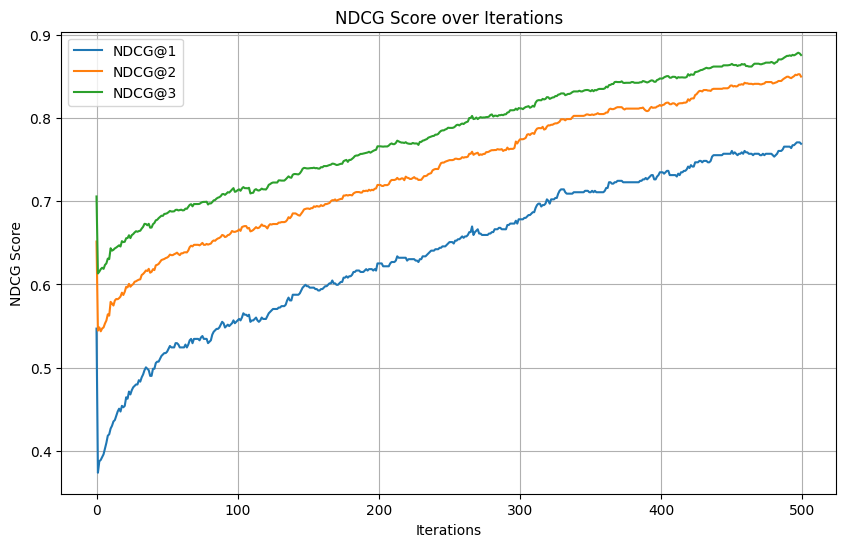

Best NDCG@1: 0.7689 in iteration: 0
Best NDCG@2: 0.8496 in iteration: 0
Best NDCG@3: 0.8755 in iteration: 0


In [27]:
# トレーニング結果の取得
evals_result = model.evals_result_

# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evals_result['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evals_result['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@1'][model.best_iteration_ - 1], model.best_iteration_))
print("Best NDCG@2: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@2'][model.best_iteration_ - 1], model.best_iteration_))
print("Best NDCG@3: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@3'][model.best_iteration_ - 1], model.best_iteration_))

In [28]:
# アンサンブル候補①LightGBM(RankNet)
# 学習データ： X_sorted_train_data, y_train_ranking
# 学習データのクエリ： train_query
# 検証データ： X_sorted_valid_data, y_valid_ranking
# 検証データのクエリ： valid_query
# テストデータ： test_ranking, y_test_true_ranking

# LightGBMデータセット
train_data = lgb.Dataset(X_sorted_train_data, label=y_train_ranking, group=train_query)
valid_data = lgb.Dataset(X_sorted_valid_data, label=y_valid_ranking, group=valid_query)
# パラメータの設定
params = {
    'objective': 'rank_xendcg',
    'metric': 'ndcg',
    'ndcg_at': [1, 2, 3],
    'n_estimators':1000,              # 決定木の個数(default:100) 5000のほうが10000より高い
    'learning_rate':0.1,            # 学習率(default:0.1)
    'num_leaves':10,                 # 決定木にある分岐の個数(default:31)
    'max_depth':10,                  # 決定木の深さの最大値(default:-1)
    "max_position":3, # 3位までの順位を予測する
    "min_data_in_leaf":40,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # "lambdarank_truncation_level":5,
}

evaluation_results = {}
# モデルの学習
ranknet_model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[lgb.record_evaluation(evaluation_results)],
)


[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: max_position


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5822
[LightGBM] [Info] Number of data points in the train set: 26926, number of used features: 48
[LightGBM] [Warning] Unknown parameter: max_position


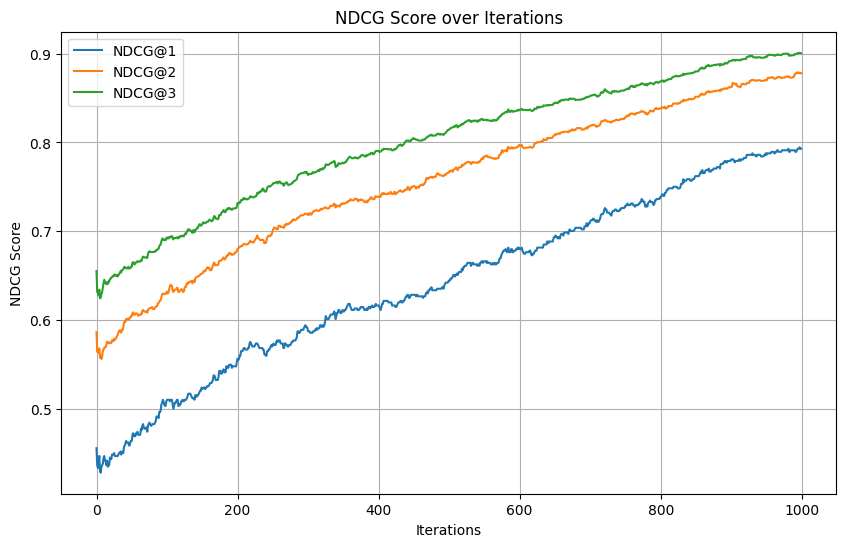

Best NDCG@1: 0.7929 in iteration: 0
Best NDCG@2: 0.8778 in iteration: 0
Best NDCG@3: 0.9003 in iteration: 0


In [29]:

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evaluation_results['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evaluation_results['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evaluation_results['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@1'], ranknet_model.best_iteration))
# 2も出力
print("Best NDCG@2: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@2'], ranknet_model.best_iteration))
# 3も出力
print("Best NDCG@3: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@3'], ranknet_model.best_iteration))


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20:40:25] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "max_position", "min_child_samples" } are not used.

[0]	validation_0-ndcg:0.70594
[100]	validation_0-ndcg:0.78977
[200]	validation_0-ndcg:0.82640
[300]	validation_0-ndcg:0.85031
[400]	validation_0-ndcg:0.86833
[500]	validation_0-ndcg:0.88483
[600]	validation_0-ndcg:0.89360
[700]	validation_0-ndcg:0.90009
[800]	validation_0-ndcg:0.90883
[900]	validation_0-ndcg:0.91127
[999]	validation_0-ndcg:0.91307


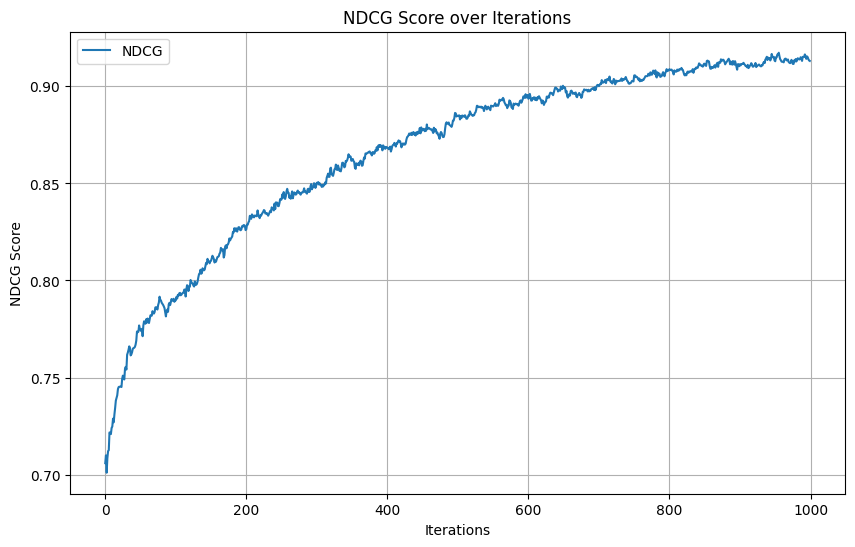

Best NDCG: 0.9173 in iteration: 955


In [30]:
# アンサンブル候補②XGBoost(Pairwise)
from xgboost import XGBRanker
# モデルの定義
pairwise_model = XGBRanker(
    objective='rank:pairwise',
    eval_metric='ndcg',
    n_estimators=1000,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    max_depth=10,                    # 決定木の深さの最大値(default:6)
    # subsample=0.8,                  # データのサンプリング比率(default:1)
    # colsample_bytree=0.8,           # 列のサンプリング比率(default:1)
    # min_child_weight=0.5,           # 葉の重みの最小値(default:1)
    # reg_lambda=1.0,                 # L2正則化の強さ(default:1)
    # gamma=0.1,                      # 葉の追加分岐を行うかの閾値(default:0)
    # n_jobs=-1,                      # 並列処理の数(default:1)
    random_state=42,                # 乱数のシード値(default:0)
    max_position=3, # 3位までの順位を予測する
    min_child_samples=30,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # lambdarank_truncation_level=5,
)
# モデルの学習
pairwise_model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    verbose=100,
    early_stopping_rounds=100,
)

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(pairwise_model.evals_result()['validation_0']['ndcg'], label='NDCG')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG: {:.4f} in iteration: {}".format(pairwise_model.best_score, pairwise_model.best_iteration))

[LightGBM] [Warning] Unknown parameter: max_position


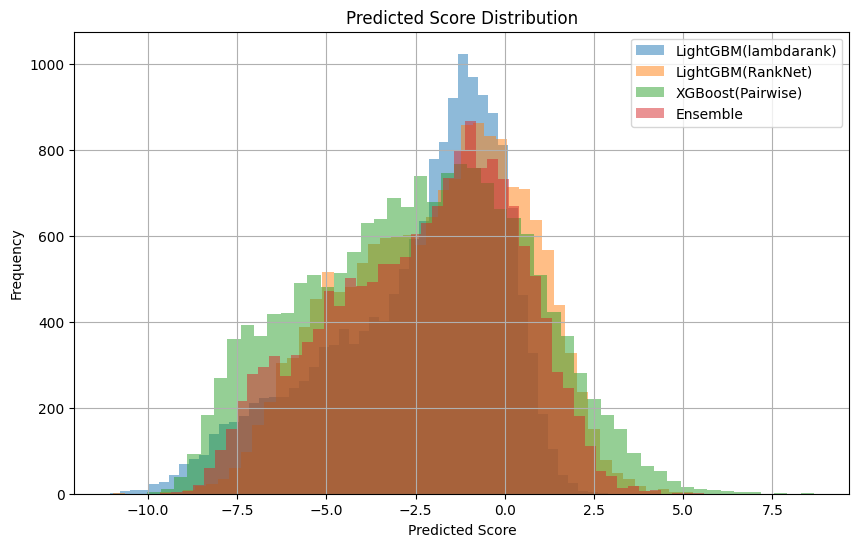

In [31]:
#　テストデータで推論
# LighGBM(lambdarank)の推論
prediction_test_ranking = model.predict(test_ranking, num_iteration=model.best_iteration_)
# LightGBM(RankNet)の推論
prediction_test_ranking_ranknet = ranknet_model.predict(test_ranking)
# XGBoost(Pairwise)の推論
prediction_test_ranking_pairwise = pairwise_model.predict(test_ranking)
# 上記の平均をアンサンブルモデルとする
prediction_test_ranking_ensemble = (prediction_test_ranking + prediction_test_ranking_ranknet + prediction_test_ranking_pairwise) / 3

df_prediction_test_ranking = pd.DataFrame({
    "馬番号": test_ranking["umaban"],
    "予測スコア(lambdarank)": prediction_test_ranking,
    "予測スコア(RankNet)": prediction_test_ranking_ranknet,
    "予測スコア(Pairwise)": prediction_test_ranking_pairwise,
    "ensemble_prediction": prediction_test_ranking_ensemble,
    "着順関連度": y_test_true_ranking,
    "着順": y_test_true_ranking_goal,
    "race_id": test_ranking_race_id,
    "distance": test_ranking["distance"],
    "ground_state": test_ranking["ground_state"],
    "weather": test_ranking["weather"],
    "condition": test_ranking["condition"],
})


# 同じレースidのうちスコアの大きい順に1位から予測順位を計算する
df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(lambdarank)"].rank(ascending=False, method='first')
df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(RankNet)"].rank(ascending=False, method='first')
df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(Pairwise)"].rank(ascending=False, method='first')
df_prediction_test_ranking["ensemble_prediction_rank"] = df_prediction_test_ranking.groupby("race_id")["ensemble_prediction"].rank(ascending=False, method='first')
# それぞれの予測順位はfloat型なのでint型に変換
df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking["予測順位(lambdarank)"].astype(int)
df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking["予測順位(RankNet)"].astype(int)
df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking["予測順位(Pairwise)"].astype(int)
df_prediction_test_ranking["ensemble_prediction_rank"] = df_prediction_test_ranking["ensemble_prediction_rank"].astype(int)

# 3つのモデルがすべて1位と判断したときだけ1位とするアンサンブルモデル
# df_prediction_test_ranking['ensemble_prediction'] = (
#     (df_prediction_test_ranking['予測順位(lambdarank)'] == 1) &
#     (df_prediction_test_ranking['予測順位(RankNet)'] == 1) &
#     (df_prediction_test_ranking['予測順位(Pairwise)'] == 1)
# ).astype(int)

# 予測スコアの分布を可視化
plt.figure(figsize=(10, 6))
plt.hist(prediction_test_ranking, bins=50, alpha=0.5, label='LightGBM(lambdarank)')
plt.hist(prediction_test_ranking_ranknet, bins=50, alpha=0.5, label='LightGBM(RankNet)')
plt.hist(prediction_test_ranking_pairwise, bins=50, alpha=0.5, label='XGBoost(Pairwise)')
plt.hist(prediction_test_ranking_ensemble, bins=50, alpha=0.5, label='Ensemble')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.title('Predicted Score Distribution')
plt.legend()
plt.grid(True)
plt.show()



LightGBM(lambdarank)の評価
True Positive: 458
False Positive: 767
False Negative: 769
True Negative: 14493
Precision: 0.3739
Recall: 0.3733
F1 Score: 0.3736


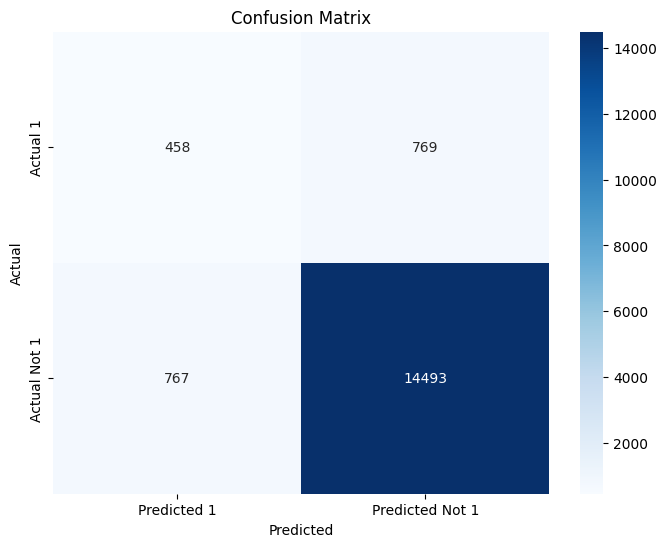

LightGBM(RankNet)の評価
True Positive: 476
False Positive: 749
False Negative: 751
True Negative: 14511
Precision: 0.3886
Recall: 0.3879
F1 Score: 0.3883


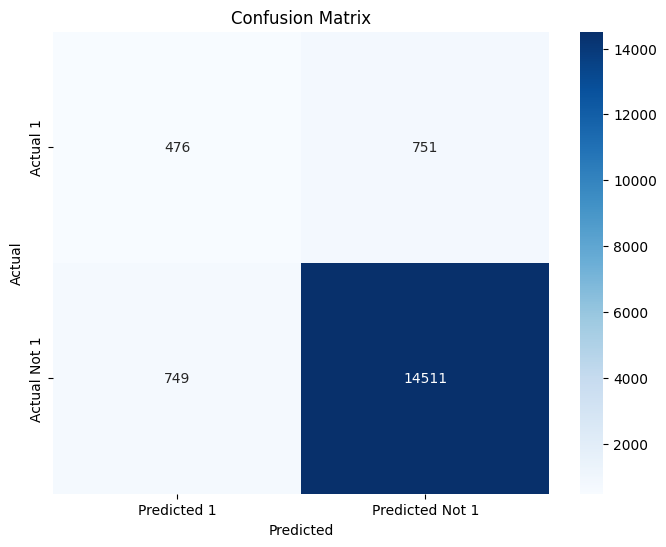

XGBoost(Pairwise)の評価
True Positive: 433
False Positive: 792
False Negative: 794
True Negative: 14468
Precision: 0.3535
Recall: 0.3529
F1 Score: 0.3532


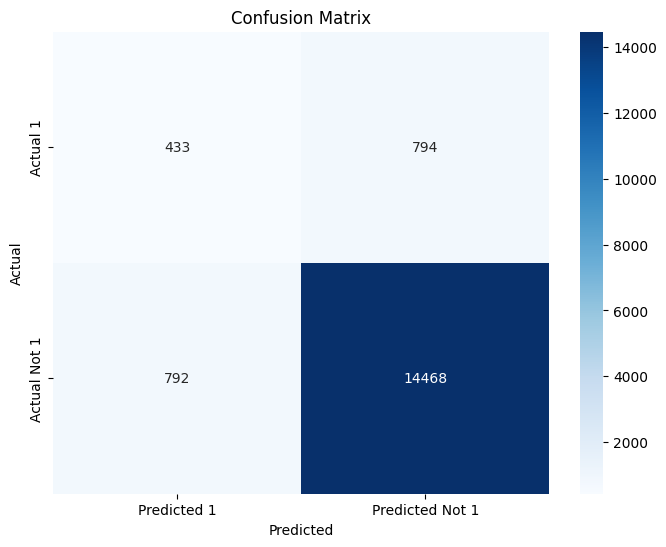

アンサンブルモデルの評価
True Positive: 473
False Positive: 752
False Negative: 754
True Negative: 14508
Precision: 0.3861
Recall: 0.3855
F1 Score: 0.3858


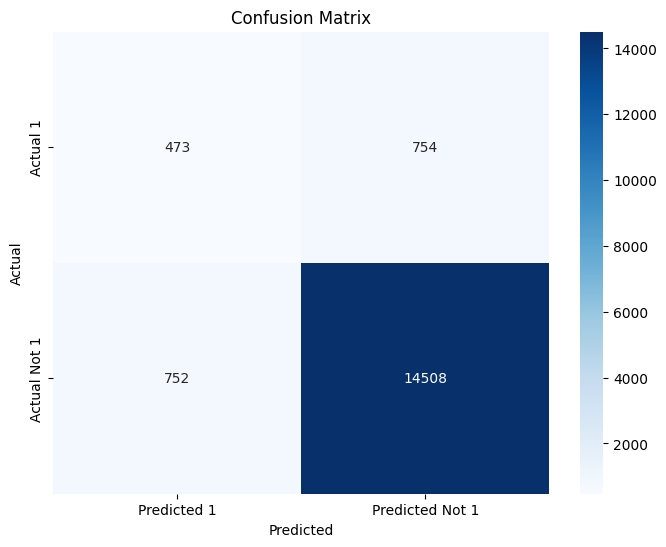

In [32]:
# 1位のスコアにおける予測結果の評価
print("LightGBM(lambdarank)の評価")
rank_evaluation(df_prediction_test_ranking, '予測順位(lambdarank)')
print("LightGBM(RankNet)の評価")
rank_evaluation(df_prediction_test_ranking, '予測順位(RankNet)')
print("XGBoost(Pairwise)の評価")
rank_evaluation(df_prediction_test_ranking, '予測順位(Pairwise)')
print("アンサンブルモデルの評価")
rank_evaluation(df_prediction_test_ranking, 'ensemble_prediction_rank')

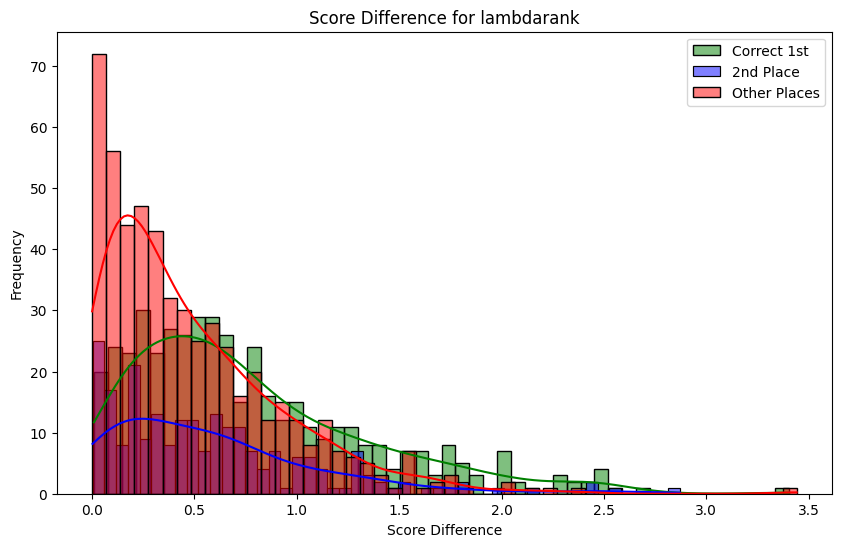

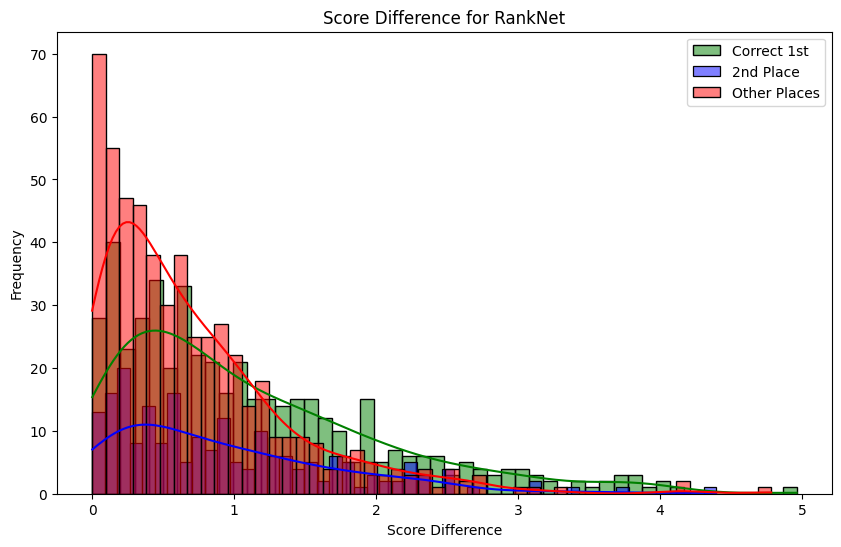

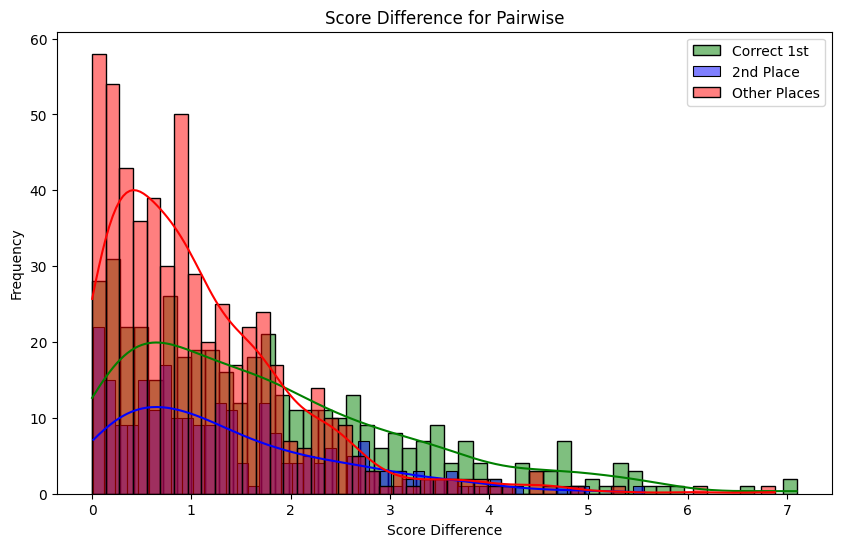

Optimal Threshold (ROC) for lambdarank: 0.6776001076416549
Optimal Threshold (Precision-Recall) for lambdarank: 0.0037143298254590507
Optimal Threshold (ROC) for RankNet: 0.9874550941307105
Optimal Threshold (Precision-Recall) for RankNet: 0.0011262936810760849
Optimal Threshold (ROC) for Pairwise: 2.328358232975006
Optimal Threshold (Precision-Recall) for Pairwise: 0.00019788742065429688
Precision for lambdarank: 0.4905
Recall for lambdarank: 0.1687
F1 Score for lambdarank: 0.2511


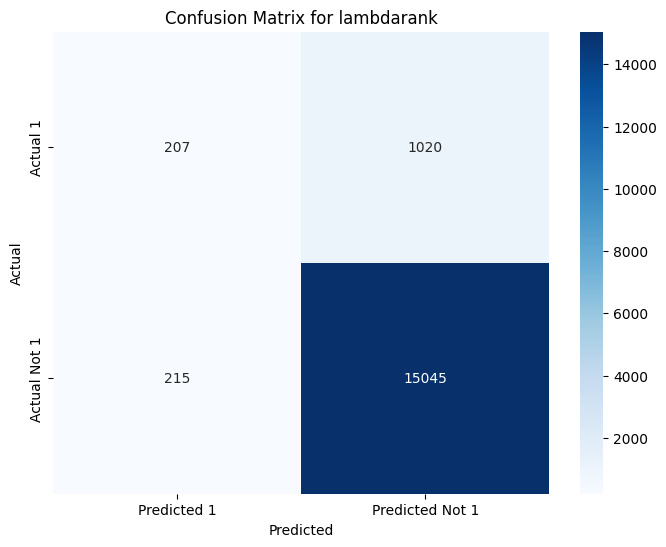

Precision for RankNet: 0.4953
Recall for RankNet: 0.1720
F1 Score for RankNet: 0.2553


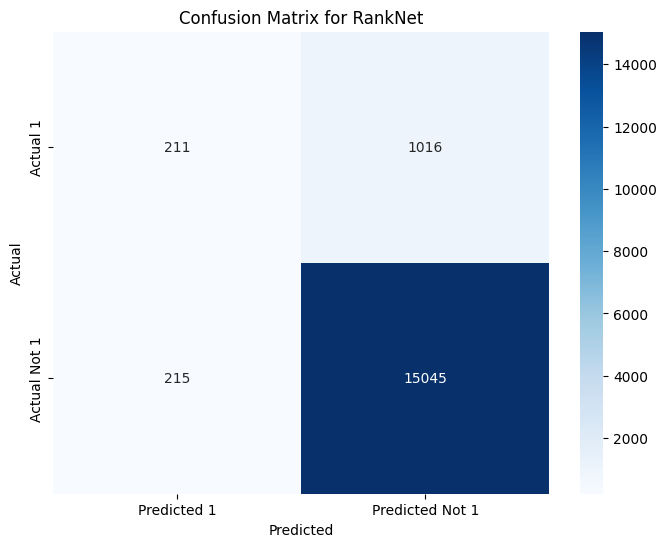

Precision for Pairwise: 0.5482
Recall for Pairwise: 0.1019
F1 Score for Pairwise: 0.1718


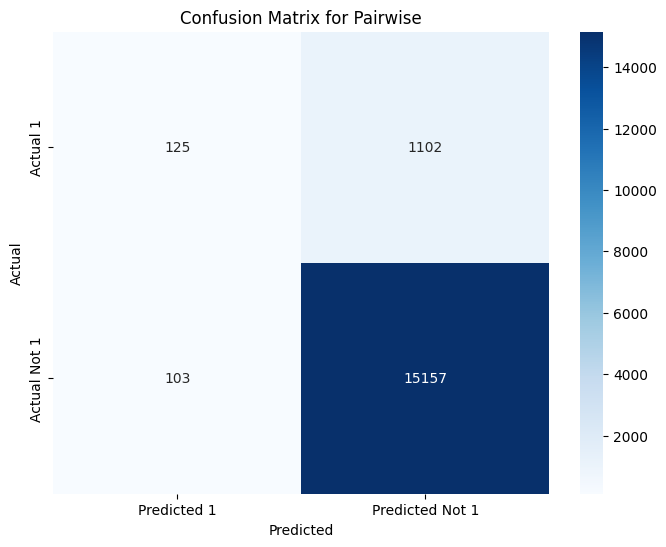

In [33]:
# 1位と2位のスコアの差を可視化する→閾値を決定してコンフュージョンマトリックスで正解率を確認する
df_prediction_test_ranking['score_diff_lambdarank'] = calculate_score_diff(df_prediction_test_ranking, 'lambdarank')
df_prediction_test_ranking['score_diff_RankNet'] = calculate_score_diff(df_prediction_test_ranking, 'RankNet')
df_prediction_test_ranking['score_diff_Pairwise'] = calculate_score_diff(df_prediction_test_ranking, 'Pairwise')

plot_score_diff(df_prediction_test_ranking, 'lambdarank', 1)
plot_score_diff(df_prediction_test_ranking, 'RankNet', 1)
plot_score_diff(df_prediction_test_ranking, 'Pairwise', 1)

optimal_threshold_lambdarank, optimal_threshold_pr_lambdarank = find_optimal_threshold(df_prediction_test_ranking, 'lambdarank',1)
optimal_threshold_ranknet, optimal_threshold_pr_ranknet = find_optimal_threshold(df_prediction_test_ranking, 'RankNet',1)
optimal_threshold_pairwise, optimal_threshold_pr_pairwise = find_optimal_threshold(df_prediction_test_ranking, 'Pairwise',1)
print(f'Optimal Threshold (ROC) for lambdarank: {optimal_threshold_lambdarank}')
print(f'Optimal Threshold (Precision-Recall) for lambdarank: {optimal_threshold_pr_lambdarank}')
print(f'Optimal Threshold (ROC) for RankNet: {optimal_threshold_ranknet}')
print(f'Optimal Threshold (Precision-Recall) for RankNet: {optimal_threshold_pr_ranknet}')
print(f'Optimal Threshold (ROC) for Pairwise: {optimal_threshold_pairwise}')
print(f'Optimal Threshold (Precision-Recall) for Pairwise: {optimal_threshold_pr_pairwise}')

df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'lambdarank', optimal_threshold_lambdarank)
df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'RankNet', optimal_threshold_ranknet)
df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'Pairwise', optimal_threshold_pairwise)

evaluate_predictions(df_prediction_test_ranking, 'lambdarank')
evaluate_predictions(df_prediction_test_ranking, 'RankNet')
evaluate_predictions(df_prediction_test_ranking, 'Pairwise')

In [34]:
# # 1位-2位のスコア/標準偏差を計算でやってみたけどrecallがあがってprecisionが下がる結果に。
# ->未メンテ。
# evaluate_predictions_std(df_prediction_test_ranking, 'lambdarank')
# evaluate_predictions_std(df_prediction_test_ranking, 'RankNet')
# evaluate_predictions_std(df_prediction_test_ranking, 'Pairwise')

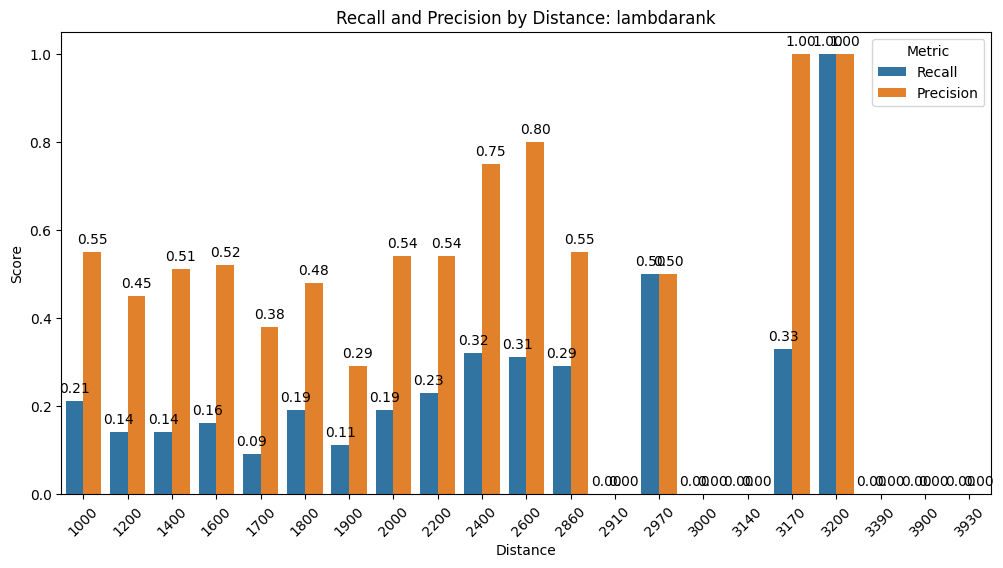

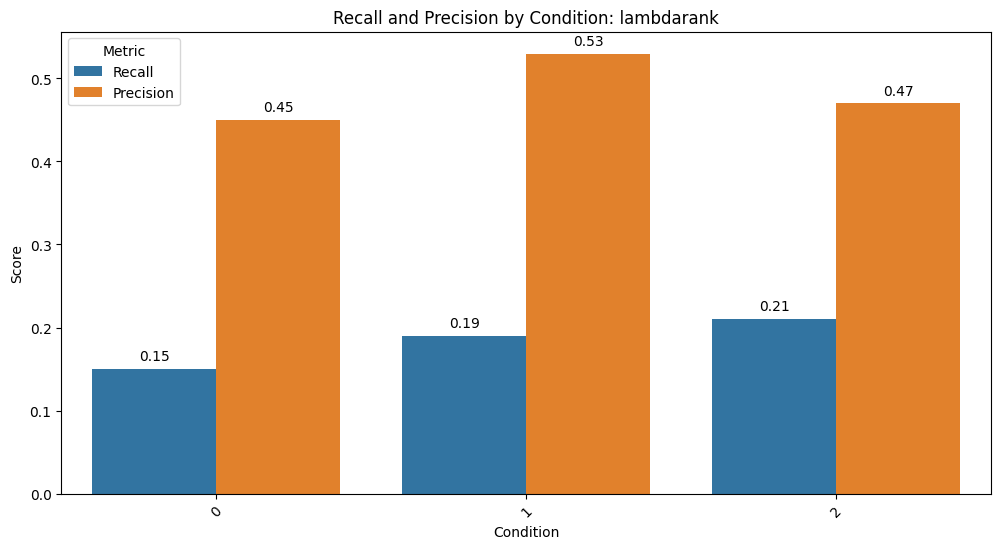

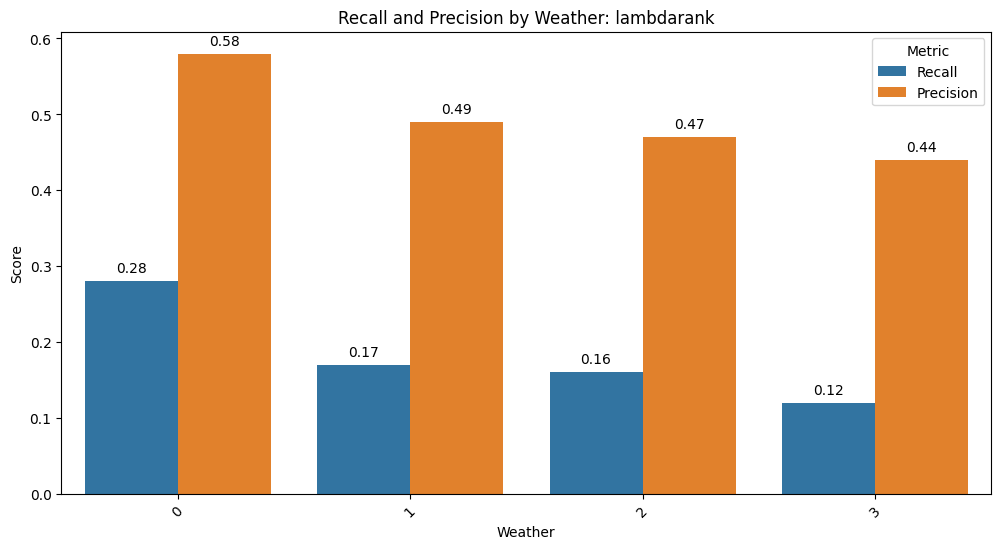

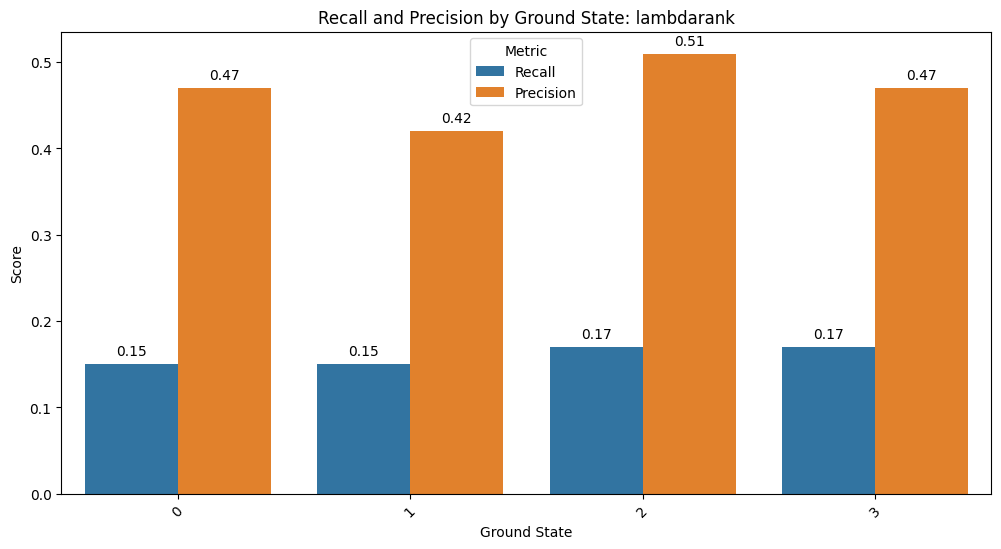

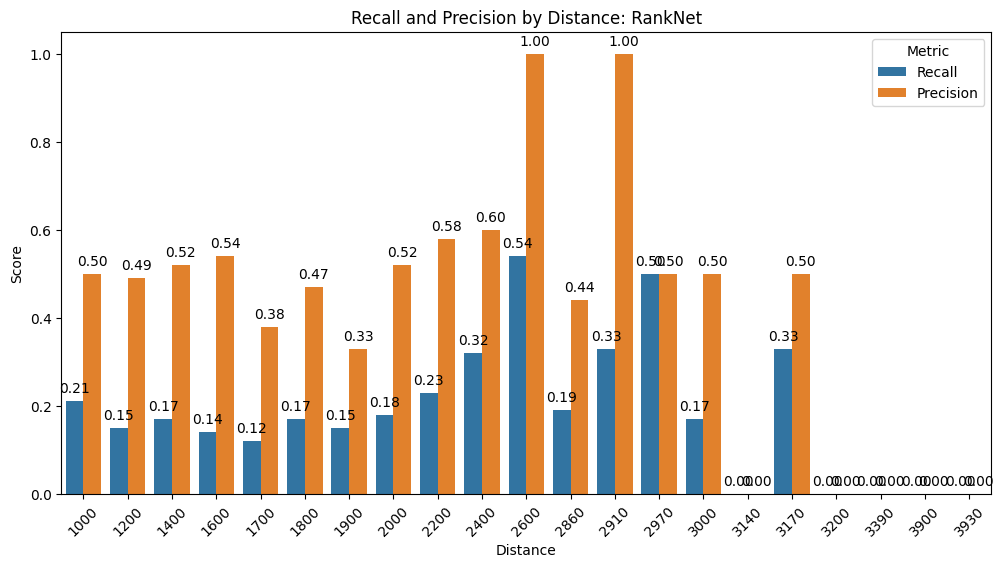

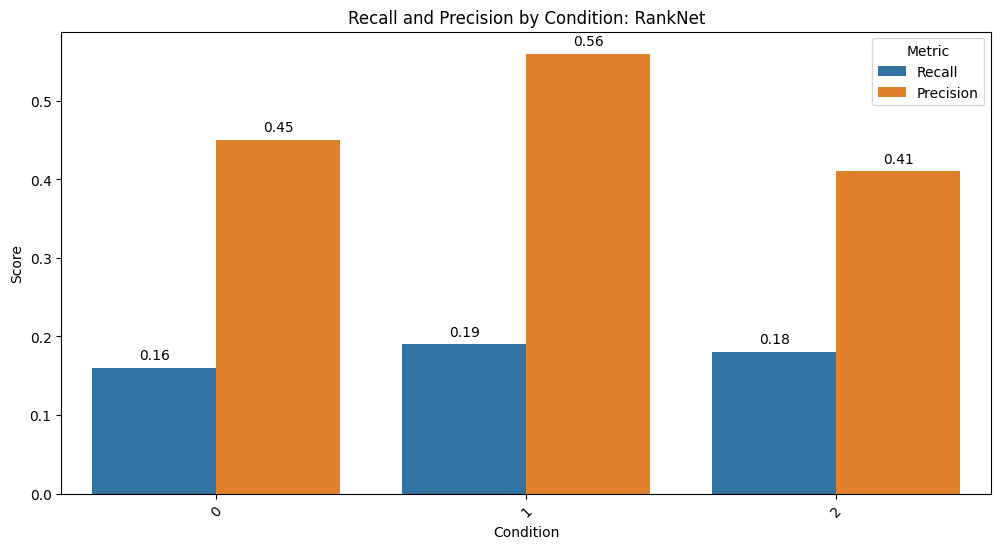

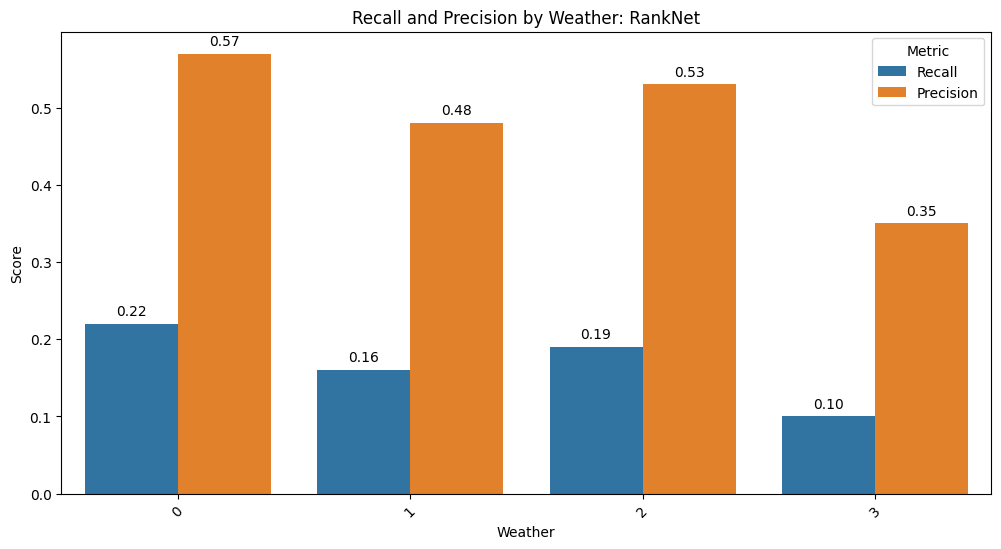

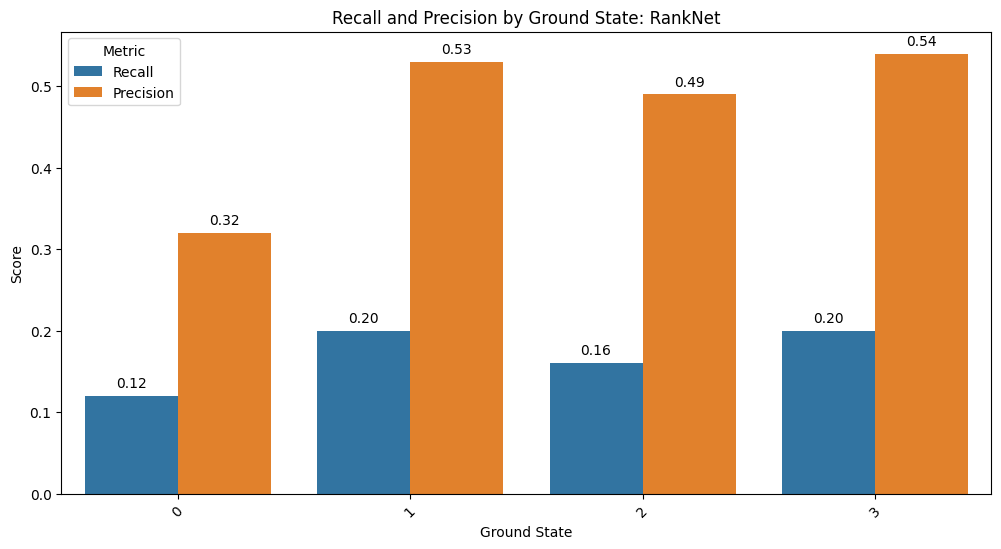

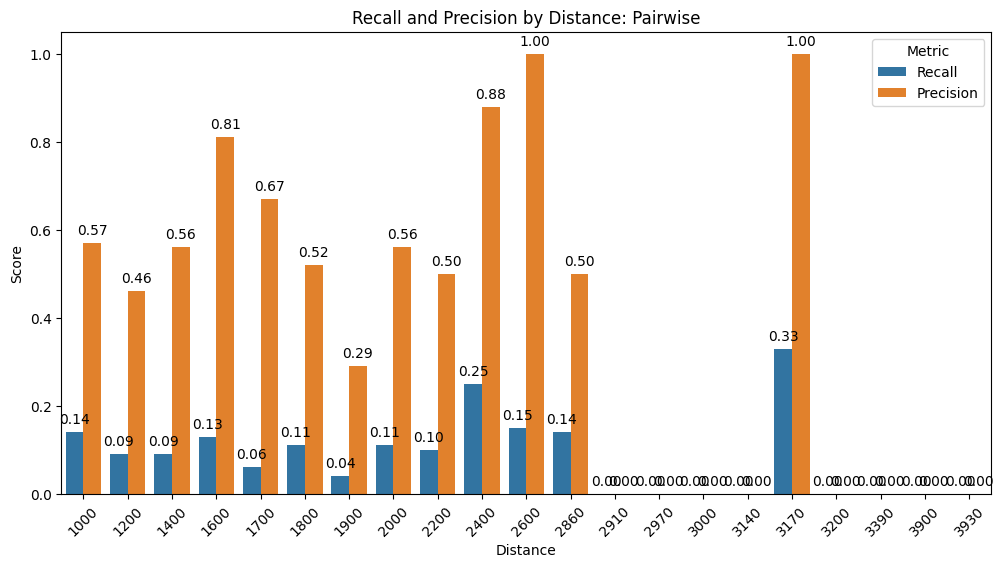

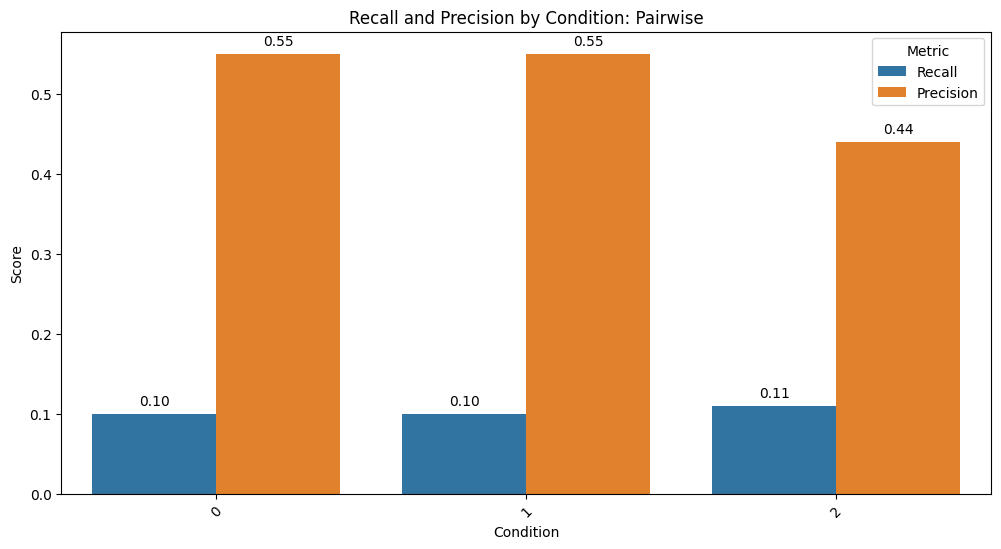

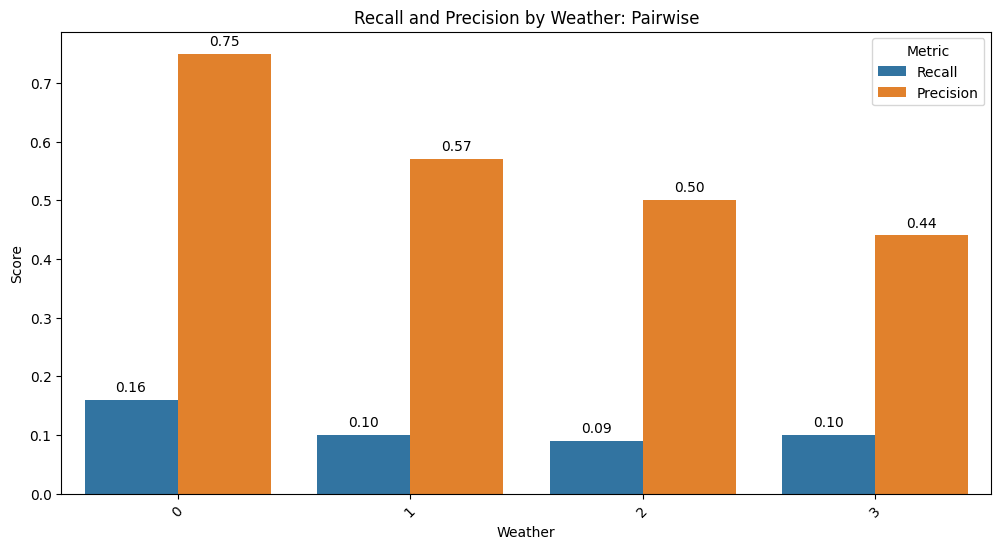

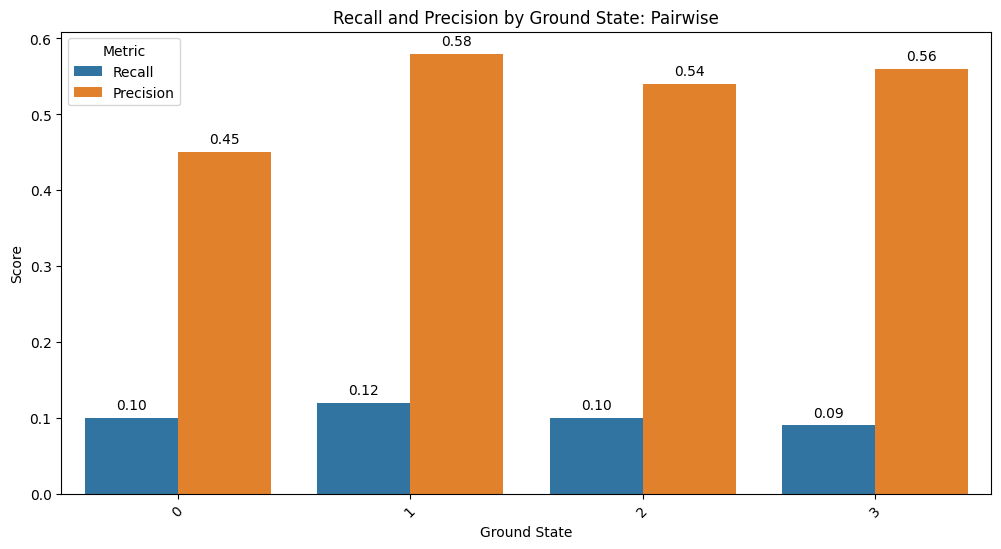

In [35]:
# 予測結果に対して距離、天気、馬場状態、コースの特長量ごとに予測精度が変わらないかを可視化する。
model_evaluation_by_feature(df_prediction_test_ranking, 'lambdarank')
model_evaluation_by_feature(df_prediction_test_ranking, 'RankNet')
model_evaluation_by_feature(df_prediction_test_ranking, 'Pairwise')

# condition
# ['ダ' '芝' '障']
# weather
# ['小雨' '晴' '曇' '雨']
# ground_state
# ['不良' '稍重' '良' '重']

In [36]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

   

# 各モデルに対して馬連のprecisionを計算
models = ['予測順位(lambdarank)', '予測順位(Pairwise)', '予測順位(RankNet)']
for model_ in models:
    umaren_precision(df_prediction_test_ranking, model_)

1225
202
precision rate 0.16489795918367348
1225
228
precision rate 0.18612244897959185
1225
222
precision rate 0.18122448979591838


In [37]:
# 特徴重要度の可視化
df_importance = pd.DataFrame({"columns": X_sorted_train_data.columns, "importance": model.feature_importances_})
df_importance.sort_values("importance", ascending=False, inplace=True)
print(df_importance)

            columns  importance
13            1/オッズ         260
19            pace1         224
45         odds_std         220
24               賞金         211
18            タイム_y         201
6          odds_inv         196
20            pace2         180
46    odds_diff-1-2         179
21               上り         174
47    odds_diff-1-3         174
22   horse_weight_y         159
23  weight_change_y         138
2            umaban         134
36           peds_1         122
39           peds_4         116
40           peds_5         105
28              4着〜         103
10               頭数          97
38           peds_3          96
0          distance          91
16               距離          89
11               枠番          86
35           peds_0          86
32               勝率          82
5             handi          76
14               人気          73
41         log_odds          72
37           peds_2          68
43      zscore_odds          66
34              複勝率          58
3       

In [38]:
# カレントディレクトリにモデルを保存
import pickle
with open('pkl_registory/lambdarank_model.pkl', 'wb') as f:
    pickle.dump(model, f)
# カレントディレクトリにranknet_modelモデルを保存
with open('pkl_registory/ranknet_model.pkl', 'wb') as f:
    pickle.dump(ranknet_model, f)
# カレントディレクトリにpairwise_modelモデルを保存
with open('pkl_registory/pairwise_model.pkl', 'wb') as f:
    pickle.dump(pairwise_model, f)

In [39]:
from pathlib import Path
import pandas as pd
import tqdm
from utils.utils_inference import *
import os

# 青色で出力
# "RankNetの正答率が高い"
print("\033[34m二つのモデルで1位が出てくるときはオッズがつくならワイドあり\033[0m")
# csvデータを1つずつ読み出し推論
p = Path(inference_data_path)
files = list(p.glob("*inference*.csv"))
print(p)
print(files)
count = 0
for file in tqdm.tqdm(files):
    # 読み込んだファイル名を出力
    # print("=======予測ファイル名======== {}".format(file))
    print("=======予測ファイル名========\n {}".format(file))
    inference_data = pd.read_csv(file, encoding='utf-8')
    # データの確認
    # print(inference_data.info())

    # Unnamed: 0,class_list_in_raceを削除
    # inference_data = inference_data.drop(['Unnamed: 0',"class_list_in_race","date"], axis=1)
    # inference_data.info()
    inference_data['連対率'] = inference_data['連対率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) and x.strip() not in ['％', '-'] else 0.0
    )

    # '勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['勝率'] = inference_data['勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) and x.strip() not in ['％', '-'] else 0.0
    )
    
    # '複勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['複勝率'] = inference_data['複勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) and x.strip() not in ['％', '-'] else 0.0
    )
    #　=================real dataで推論=============================
    inference_data, inference_data_odds, inference_data_race_id,inference_data_answer = preprocess_for_inference(inference_data)
    # オッズの差分を計算して新しい特徴量として追加
    inference_data = add_odds_differences_for_inference(inference_data)
    

    # X_sorted_train_data.columnsの日本語文字列の半角、全角スペースを削除する
    # X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace(' ', '')
    # X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace('　', '')
    

    # inference_dataの特長量を設定する
    inference_data_for_predict = inference_data[X_sorted_train_data.columns]

    # ラベルエンコーディングは前処理終了後
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = inference_data_for_predict.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        # object型は別のラベル名にてラベルエンコーディングする
        inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])

    # 対数変換実施
    # inference_data = log_transform(inference_data)

    # 標準化実施
    # inference_data = standard_scaler(inference_data)

    # モデル予測
    prediction_inference_ranking = model.predict(inference_data_for_predict, num_iteration=model.best_iteration_)
    prediction_inference_ranking_ranknet = ranknet_model.predict(inference_data_for_predict)
    prediction_inference_ranking_pairwise = pairwise_model.predict(inference_data_for_predict)

    inference_data["予測スコア(lambdarank)"] = prediction_inference_ranking
    inference_data["予測スコア(RankNet)"] = prediction_inference_ranking_ranknet
    inference_data["予測スコア(Pairwise)"] = prediction_inference_ranking_pairwise
    inference_data["goal_number"] = inference_data_answer
    # 2位予測用にデータを保存
    inference_data.to_csv(file, index=False)

    # シンプルに予測結果の平均を取る
    prediction_inference = (prediction_inference_ranking + prediction_inference_ranking_ranknet + prediction_inference_ranking_pairwise) / 3
    # データフレームを作成
    df_prediction_test_ranking = pd.DataFrame({
        "horse_id": inference_data["umaban"],
        "予測スコア(lambdarank)": prediction_inference_ranking,
        "予測スコア(RankNet)": prediction_inference_ranking_ranknet,
        "予測スコア(Pairwise)": prediction_inference_ranking_pairwise,
        "predict_amsamble": prediction_inference,
        "odds": inference_data_odds,
        "goal": inference_data_answer,
        "race_id": inference_data_race_id,
        "distance": inference_data["distance"],
        "condition": inference_data["condition"],
        "weather": inference_data["weather"],
        "ground_state": inference_data["ground_state"],
    })

    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア(lambdarank)", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking["予測スコア(lambdarank)"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア(RankNet)", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking["予測スコア(RankNet)"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア(Pairwise)", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking["予測スコア(Pairwise)"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="predict_amsamble", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(amsamble)"] = df_prediction_test_ranking["predict_amsamble"].rank(ascending=False, method='first').astype(int)
    # インデックスをリセット
    df_prediction_test_ranking = df_prediction_test_ranking.reset_index(drop=True)
    # 最後に着順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="goal")

    # 結果を確認
    # print(df_prediction_test_ranking.head())
    # pandasをcsvに保存
    # inference_data_path + /inference_resultにディレクトリを作成し、csvを保存する
    inference_data_path_result = inference_data_path + "inference_result/"
    if not os.path.isdir(inference_data_path_result):
        os.mkdir(inference_data_path_result)
    file_name = file.name
    saving_path = inference_data_path_result + "prediction_" +  str(file_name) + "_.csv"
    # print("saving_path:{}".format(saving_path))
    df_prediction_test_ranking.to_csv(saving_path, index=False)

    # 推論データに対して予測を行う。1位と2位のスコアの差を計算し、閾値を適用して各モデルごとに1位を予測する
    df_prediction_test_ranking = prediction_print(df_prediction_test_ranking,optimal_threshold_lambdarank,optimal_threshold_ranknet,optimal_threshold_pairwise)

    # =================================================================
    # 予測結果がシビアすぎて全然買い目が出ないので過去の情報も一応出力しておく
    # =================================================================
    # すべてのモデルのスコアが正で1位かつスコアが0以上のものをフィルタリング
    # utils_inference.add_prediction_info(df_prediction_test_ranking)

    count +=1


二つのモデルで1位が出てくるときはオッズがつくならワイドあり
/home/hayato/horse_inference/inference/2025060201/add_dynamic_data
[PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602019.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602018.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_202506020110.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602015.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602016.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602011.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602017.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201

  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602019.csv
[LightGBM] [Warning] Unknown parameter: max_position
1位と予測した数(lambdarank): 1
   horse_id  予測スコア(lambdarank)  予測スコア(RankNet)  予測スコア(Pairwise)   
0         7          -1.333727       -1.622418        -0.840039  \

   predict_amsamble  odds  goal race_id  distance condition  ...   
0         -1.265395  53.9   NaN    test      2200         芝  ...  \

  予測順位(lambdarank)  予測順位(RankNet)  予測順位(Pairwise)  予測順位(amsamble)   
0                1              2               3               1  \

   score_diff_lambdarank  score_diff_RankNet  score_diff_Pairwise   
0               0.822373            0.033807             0.260445  \

   予測結果(lambdarank)  予測結果(RankNet)  予測結果(Pairwise)  
0                 1              0               0  

[1 rows x 22 columns]
RankNet:1位と予測した時の2位とのスコアの差: 0.033807201747349636
RankNet:閾値: 0.9874550941307105
Pairwise:1位と予測した時の2位とのスコアの差: 0.260

/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

[LightGBM] [Warning] Unknown parameter: max_position


/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

1位と予測した数(RankNet): 1
   horse_id  予測スコア(lambdarank)  予測スコア(RankNet)  予測スコア(Pairwise)   
0         6             -3.822       -1.455626        -2.696656  \

   predict_amsamble  odds  goal race_id  distance condition  ...   
0         -2.658094   9.8   NaN    test      1800         芝  ...  \

  予測順位(lambdarank)  予測順位(RankNet)  予測順位(Pairwise)  予測順位(amsamble)   
0                7              1               4               1  \

   score_diff_lambdarank  score_diff_RankNet  score_diff_Pairwise   
0                0.00135            1.154459             0.040811  \

   予測結果(lambdarank)  予測結果(RankNet)  予測結果(Pairwise)  
0                 0              1               0  

[1 rows x 22 columns]
lambdarank:1位と予測した時の2位とのスコアの差: 0.0013502305994439467
lambdarank:閾値: 0.6776001076416549
Pairwise:1位と予測した時の2位とのスコアの差: 0.04081070423126221
Pairwise:閾値: 2.328358232975006
distance: 1800
スコアは高いけど、距離が2000m未満
condition: 芝
conditionは3以外の時正答率高い
weather: 晴
weatherは0以外の時正答率高い

ground_state: nan
=======予測ファイル名=

/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_202506020111.csv
[LightGBM] [Warning] Unknown parameter: max_position


/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_data_for_predict[column] = le.fit_transform(inference_data_for_predict[column])
/tmp/ipykernel_28065/3136823718.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602013.csv
[LightGBM] [Warning] Unknown parameter: max_position
1位と予測した数(RankNet): 1
   horse_id  予測スコア(lambdarank)  予測スコア(RankNet)  予測スコア(Pairwise)   
0        16          -2.115425       -2.658862         -2.72551  \

   predict_amsamble  odds  goal race_id  distance condition  ...   
0         -2.499932   7.6   NaN    test      1800         ダ  ...  \

  予測順位(lambdarank) 予測順位(RankNet)  予測順位(Pairwise)  予測順位(amsamble)   
0                1             1               4               1  \

   score_diff_lambdarank  score_diff_RankNet  score_diff_Pairwise   
0               0.124872            1.099593             0.161917  \

   予測結果(lambdarank)  予測結果(RankNet)  予測結果(Pairwise)  
0                 0              1               0  

[1 rows x 22 columns]
lambdarank:1位と予測した時の2位とのスコアの差: 0.12487229507730868
lambdarank:閾値: 0.6776001076416549
Pairwise:1位と予測した時の2位とのスコアの差: 0.161

In [ ]:
# 2位の予測モデルの生成
# 各モデルのスコアを計算する関数
def add_model_scores(data, model, model_name):
    scores = model.predict(data[X_sorted_train_data.columns])
    data[f'pred_score_{model_name}'] = scores
    return data

# 学習データにスコアを追加
# X_sorted_train_data_copy = add_model_scores(X_sorted_train_data_copy, model, 'lambdarank')
# X_sorted_train_data_copy = add_model_scores(X_sorted_train_data_copy, ranknet_model, 'RankNet')
X_sorted_train_data_copy = add_model_scores(X_sorted_train_data_copy, pairwise_model, 'Pairwise')

# 検証データにスコアを追加
# X_sorted_valid_data_copy = add_model_scores(X_sorted_valid_data_copy, model, 'lambdarank')
# X_sorted_valid_data_copy = add_model_scores(X_sorted_valid_data_copy, ranknet_model, 'RankNet')
X_sorted_valid_data_copy = add_model_scores(X_sorted_valid_data_copy, pairwise_model, 'Pairwise')

# テストデータにスコアを追加
# test_ranking_copy = add_model_scores(test_ranking_copy, model, 'lambdarank')
# test_ranking_copy = add_model_scores(test_ranking_copy, ranknet_model, 'RankNet')
test_ranking_copy = add_model_scores(test_ranking_copy, pairwise_model, 'Pairwise')

def add_race_features(data, model_name, race_id=True):
    if race_id:
        # 学習データでrace_idがクエリになるようにしている
        groupby_obj = data.groupby("race_id")
    else:
        # 推論データでrace_idがない場合は全体をグループ化
        groupby_obj = data

    if race_id:
        # 1位のスコア
        top_scores = groupby_obj[f'pred_score_{model_name}'].transform('max')
        data[f'top_score_{model_name}'] = top_scores
        
        # 各馬のスコアと1位のスコアの差分
        data[f'score_diff_{model_name}'] = top_scores - data[f'pred_score_{model_name}']
        
        # 1位と2位のスコアの差分
        second_scores = groupby_obj[f'pred_score_{model_name}'].transform(lambda x: x.nlargest(2).iloc[-1])
        data[f'top2_score_diff_{model_name}'] = top_scores - second_scores
        
        # レース内でのスコアの標準偏差
        data[f'score_std_{model_name}'] = groupby_obj[f'pred_score_{model_name}'].transform('std')
        
        # レース内でのスコアの最大-最小
        data[f'score_range_{model_name}'] = groupby_obj[f'pred_score_{model_name}'].transform(lambda x: x.max() - x.min())
        
        # 1位のスコアと平均スコアの差
        mean_scores = groupby_obj[f'pred_score_{model_name}'].transform('mean')
        data[f'top_mean_score_diff_{model_name}'] = top_scores - mean_scores
        
        # 上位3頭のスコアの平均
        top3_mean_scores = groupby_obj[f'pred_score_{model_name}'].transform(lambda x: x.nlargest(3).mean())
        data[f'top3_mean_score_{model_name}'] = top3_mean_scores
        
        # 2位以下のスコアの平均
        below2_mean_scores = groupby_obj[f'pred_score_{model_name}'].transform(lambda x: x.nsmallest(len(x)-1).mean())
        data[f'below2_mean_score_{model_name}'] = below2_mean_scores
        
        # 2位以下のスコアの標準偏差
        below2_std_scores = groupby_obj[f'pred_score_{model_name}'].transform(lambda x: x.nsmallest(len(x)-1).std())
        data[f'below2_score_std_{model_name}'] = below2_std_scores
        
        # 2位と3位のスコア差
        third_scores = groupby_obj[f'pred_score_{model_name}'].transform(lambda x: x.nlargest(3).iloc[-1])
        data[f'second_third_score_diff_{model_name}'] = second_scores - third_scores
        
        # 2位と最下位のスコア差
        last_scores = groupby_obj[f'pred_score_{model_name}'].transform('min')
        data[f'second_last_score_diff_{model_name}'] = second_scores - last_scores
    else:
        # 1位のスコア
        top_score = data[f'pred_score_{model_name}'].max()
        data[f'top_score_{model_name}'] = top_score
        
        # 各馬のスコアと1位のスコアの差分
        data[f'score_diff_{model_name}'] = top_score - data[f'pred_score_{model_name}']
        
        # 1位と2位のスコアの差分
        second_score = data[f'pred_score_{model_name}'].nlargest(2).iloc[-1]
        data[f'top2_score_diff_{model_name}'] = top_score - second_score
        
        # スコアの標準偏差
        score_std = data[f'pred_score_{model_name}'].std()
        data[f'score_std_{model_name}'] = score_std
        
        # スコアの最大-最小
        score_range = data[f'pred_score_{model_name}'].max() - data[f'pred_score_{model_name}'].min()
        data[f'score_range_{model_name}'] = score_range
        
        # 1位のスコアと平均スコアの差
        mean_score = data[f'pred_score_{model_name}'].mean()
        data[f'top_mean_score_diff_{model_name}'] = top_score - mean_score
        
        # 上位3頭のスコアの平均
        top3_mean_score = data[f'pred_score_{model_name}'].nlargest(3).mean()
        data[f'top3_mean_score_{model_name}'] = top3_mean_score
        
        # 2位以下のスコアの平均
        below2_mean_score = data[f'pred_score_{model_name}'].nsmallest(len(data)-1).mean()
        data[f'below2_mean_score_{model_name}'] = below2_mean_score
        
        # 2位以下のスコアの標準偏差
        below2_std_score = data[f'pred_score_{model_name}'].nsmallest(len(data)-1).std()
        data[f'below2_score_std_{model_name}'] = below2_std_score
        
        # 2位と3位のスコア差
        third_score = data[f'pred_score_{model_name}'].nlargest(3).iloc[-1]
        data[f'second_third_score_diff_{model_name}'] = second_score - third_score
        
        # 2位と最下位のスコア差
        last_score = data[f'pred_score_{model_name}'].min()
        data[f'second_last_score_diff_{model_name}'] = second_score - last_score
    
    return data

# 学習データに特長量を追加
# X_sorted_train_data_copy = add_race_features(X_sorted_train_data_copy, 'lambdarank')
# X_sorted_train_data_copy = add_race_features(X_sorted_train_data_copy, 'RankNet')
X_sorted_train_data_copy = add_race_features(X_sorted_train_data_copy, 'Pairwise')

# 検証データに特長量を追加
# X_sorted_valid_data_copy = add_race_features(X_sorted_valid_data_copy, 'lambdarank')
# X_sorted_valid_data_copy = add_race_features(X_sorted_valid_data_copy, 'RankNet')
X_sorted_valid_data_copy = add_race_features(X_sorted_valid_data_copy, 'Pairwise')

# テストデータに特長量を追加
# test_ranking_copy = add_race_features(test_ranking_copy, 'lambdarank')
# test_ranking_copy = add_race_features(test_ranking_copy, 'RankNet')
test_ranking_copy = add_race_features(test_ranking_copy, 'Pairwise')

print(test_ranking_copy.columns)



# pred_score_Pairwiseの逆数、対数化、標準化、正規化を行って性能改善するかを試す
# X_sorted_train_data_copy[f'pred_score_Pairwise_inv'] = 1 / X_sorted_train_data_copy[f'pred_score_Pairwise']
# X_sorted_valid_data_copy[f'pred_score_Pairwise_inv'] = 1 / X_sorted_valid_data_copy[f'pred_score_Pairwise']
# test_ranking_copy[f'pred_score_Pairwise_inv'] = 1 / test_ranking_copy[f'pred_score_Pairwise']
# X_sorted_train_data_copy[f'pred_score_Pairwise_log'] = np.log1p(X_sorted_train_data_copy[f'pred_score_Pairwise'])
# X_sorted_valid_data_copy[f'pred_score_Pairwise_log'] = np.log1p(X_sorted_valid_data_copy[f'pred_score_Pairwise'])
# test_ranking_copy[f'pred_score_Pairwise_log'] = np.log1p(test_ranking_copy[f'pred_score_Pairwise'])
# X_sorted_train_data_copy[f'pred_score_Pairwise_std'] = (X_sorted_train_data_copy[f'pred_score_Pairwise'] - X_sorted_train_data_copy[f'pred_score_Pairwise'].mean()) / X_sorted_train_data_copy[f'pred_score_Pairwise'].std()
# X_sorted_valid_data_copy[f'pred_score_Pairwise_std'] = (X_sorted_valid_data_copy[f'pred_score_Pairwise'] - X_sorted_valid_data_copy[f'pred_score_Pairwise'].mean()) / X_sorted_valid_data_copy[f'pred_score_Pairwise'].std()
# test_ranking_copy[f'pred_score_Pairwise_std'] = (test_ranking_copy[f'pred_score_Pairwise'] - test_ranking_copy[f'pred_score_Pairwise'].mean()) / test_ranking_copy[f'pred_score_Pairwise'].std()
# X_sorted_train_data_copy[f'pred_score_Pairwise_norm'] = (X_sorted_train_data_copy[f'pred_score_Pairwise'] - X_sorted_train_data_copy[f'pred_score_Pairwise'].min()) / (X_sorted_train_data_copy[f'pred_score_Pairwise'].max() - X_sorted_train_data_copy[f'pred_score_Pairwise'].min())
# X_sorted_valid_data_copy[f'pred_score_Pairwise_norm'] = (X_sorted_valid_data_copy[f'pred_score_Pairwise'] - X_sorted_valid_data_copy[f'pred_score_Pairwise'].min()) / (X_sorted_valid_data_copy[f'pred_score_Pairwise'].max() - X_sorted_valid_data_copy[f'pred_score_Pairwise'].min())
# test_ranking_copy[f'pred_score_Pairwise_norm'] = (test_ranking_copy[f'pred_score_Pairwise'] - test_ranking_copy[f'pred_score_Pairwise'].min()) / (test_ranking_copy[f'pred_score_Pairwise'].max() - test_ranking_copy[f'pred_score_Pairwise'].min())

# pred_score_Pairwiseの特長量寄与度が高いのでいったんなしでどうなるか見てみる-> pairwiseのスコアとっても上がりました。
X_sorted_train_data_copy.drop([f'pred_score_Pairwise'], axis=1, inplace=True)
X_sorted_valid_data_copy.drop([f'pred_score_Pairwise'], axis=1, inplace=True)
test_ranking_copy.drop([f'pred_score_Pairwise'], axis=1, inplace=True)


Index(['distance', 'condition', 'umaban', 'horse_age', 'horse_sex', 'handi',
       'odds_inv', 'weather', 'ground_state', '天気', '頭数', '枠番', '馬番', '1/オッズ',
       '人気', '斤量', '距離', '馬場', 'タイム_y', 'pace1', 'pace2', '上り',
       'horse_weight_y', 'weight_change_y', '賞金', '1着', '2着', '3着', '4着〜',
       '騎乗回数', '重賞出走', '重賞勝利', '勝率', '連対率', '複勝率', 'peds_0', 'peds_1',
       'peds_2', 'peds_3', 'peds_4', 'peds_5', 'race_id', 'goal_number',
       'goal_number_replace', 'log_odds', 'normalized_odds', 'zscore_odds',
       'odds_rank', 'odds_std', 'odds_diff-1-2', 'odds_diff-1-3',
       'pred_score_Pairwise', 'top_score_Pairwise', 'score_diff_Pairwise',
       'top2_score_diff_Pairwise', 'score_std_Pairwise',
       'score_range_Pairwise', 'top_mean_score_diff_Pairwise',
       'top3_mean_score_Pairwise', 'below2_mean_score_Pairwise',
       'below2_score_std_Pairwise', 'second_third_score_diff_Pairwise',
       'second_last_score_diff_Pairwise'],
      dtype='object')


In [41]:
# 着順1位の馬を削除
# 学習データから1位の馬を削除
def remove_top_horse(data):
    # 着順が1位の馬を削除
    data = data[data['goal_number'] != 1]
    return data
X_sorted_train_data_copy = remove_top_horse(X_sorted_train_data_copy)

# 検証データから1位の馬を削除
X_sorted_valid_data_copy = remove_top_horse(X_sorted_valid_data_copy)

# テストデータから1位の馬を削除
test_ranking_copy = remove_top_horse(test_ranking_copy)
test_ranking_race_id = test_ranking_copy["race_id"]


In [42]:
# 目的関数であるgoal_number_replaceを振りなおす。
# まずは1位の予測と同じ
X_sorted_train_data_copy['goal_number_replace'] = X_sorted_train_data_copy['goal_number'].apply(
    lambda x: 12 if x == 2 else (1 if x == 3 else 0))
X_sorted_valid_data_copy['goal_number_replace'] = X_sorted_valid_data_copy['goal_number'].apply(
    lambda x: 12 if x == 2 else (1 if x == 3 else 0))
test_ranking_copy['goal_number_replace'] = test_ranking_copy['goal_number'].apply(
    lambda x: 12 if x == 2 else (1 if x == 3 else 0))

In [43]:
# 1位の馬がなくなったのでクエリを振りなおし
# trainデータのクエリを作成
from utils.utils import create_query
train_query, X_sorted_train_data_copy = create_query(X_sorted_train_data_copy,"train")
# validデータのクエリを作成
valid_query, X_sorted_valid_data_copy = create_query(X_sorted_valid_data_copy,"valid")



Resulting list of horse counts per race (sorted by date):
[7, 11, 13, 12, 9, 13, 15, 12, 8, 8, 14, 13, 7, 13, 15, 13, 5, 15, 11, 10, 9, 13, 15, 13, 8, 13, 14, 13, 13, 11, 14, 12, 13, 7, 15, 10, 13, 11, 13, 15, 11, 12, 12, 11, 13, 13, 13, 13, 13, 11, 15, 13, 9, 15, 12, 12, 8, 13, 13, 13, 13, 13, 14, 13, 6, 13, 11, 13, 10, 10, 13, 15, 8, 13, 11, 13, 12, 15, 11, 12, 8, 10, 13, 15, 6, 11, 13, 13, 9, 13, 13, 7, 10, 8, 14, 12, 11, 13, 15, 13, 10, 13, 15, 13, 13, 15, 13, 11, 10, 11, 12, 13, 8, 11, 15, 8, 13, 13, 14, 12, 10, 4, 11, 13, 12, 13, 13, 13, 13, 13, 13, 13, 8, 13, 11, 13, 4, 15, 11, 13, 15, 13, 15, 13, 7, 13, 15, 13, 12, 11, 15, 13, 15, 13, 9, 13, 10, 8, 13, 15, 13, 15, 13, 13, 13, 11, 13, 13, 15, 13, 11, 15, 10, 13, 8, 10, 7, 12, 12, 11, 15, 13, 11, 15, 10, 15, 10, 10, 15, 13, 15, 11, 15, 13, 10, 11, 13, 11, 13, 11, 10, 8, 14, 13, 13, 15, 11, 12, 10, 12, 11, 15, 10, 12, 15, 14, 9, 9, 15, 10, 4, 10, 10, 12, 7, 12, 15, 11, 15, 8, 11, 13, 5, 9, 8, 13, 12, 11, 12, 12, 8, 11, 11, 8, 5, 

In [44]:
# 1========================================================
y_train_ranking = X_sorted_train_data_copy['goal_number_replace']
y_valid_ranking = X_sorted_valid_data_copy['goal_number_replace']
y_test_true_ranking = test_ranking_copy['goal_number_replace']
# 2========================================================
y_train_ranking_goal = X_sorted_train_data_copy['goal_number']
y_valid_ranking_goal = X_sorted_valid_data_copy['goal_number']
y_test_true_ranking_goal = test_ranking_copy['goal_number']
# 3========================================================
X_sorted_train_data_copy = X_sorted_train_data_copy.drop('goal_number', axis=1)
X_sorted_valid_data_copy = X_sorted_valid_data_copy.drop('goal_number', axis=1)
test_ranking_copy = test_ranking_copy.drop('goal_number', axis=1)
# 4========================================================
X_sorted_train_data_copy = X_sorted_train_data_copy.drop('goal_number_replace', axis=1)
X_sorted_valid_data_copy = X_sorted_valid_data_copy.drop('goal_number_replace', axis=1)
test_ranking_copy = test_ranking_copy.drop('goal_number_replace', axis=1)
# 5========================================================
X_sorted_train_data_copy = X_sorted_train_data_copy.drop('race_id', axis=1)
X_sorted_valid_data_copy = X_sorted_valid_data_copy.drop('race_id', axis=1)
test_ranking_copy = test_ranking_copy.drop('race_id', axis=1)

In [45]:
# スクレイピングするごとにカラム名が変化してくので、カラム名のスペースを削除する処理を学習前に追加
# X_sorted_train_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_train_data_copy.columns = X_sorted_train_data_copy.columns.str.replace(' ', '')
X_sorted_train_data_copy.columns = X_sorted_train_data_copy.columns.str.replace('　', '')

# X_sorted_valid_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_valid_data_copy.columns = X_sorted_valid_data_copy.columns.str.replace(' ', '')
X_sorted_valid_data_copy.columns = X_sorted_valid_data_copy.columns.str.replace('　', '')

# test_ranking.columnsの日本語文字列の半角、全角スペースを削除する
test_ranking_copy.columns = test_ranking_copy.columns.str.replace(' ', '')
test_ranking_copy.columns = test_ranking_copy.columns.str.replace('　', '')

# データ確認用にX_sorted_train_data_copyを保存
X_sorted_train_data_copy.to_csv("X_sorted_train_data_copy.csv", index=False)


In [46]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.metrics import ndcg_score

# データの準備
# X_sorted_train_data, y_train_ranking, train_query
# X_sorted_valid_data, y_valid_ranking, valid_query

# ランキング学習
lambdarank_model_second = lgb.LGBMRanker(
    random_state=42,
    objective='lambdarank',
    metric='ndcg',
    n_estimators=500,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    num_leaves=10,                 # 決定木にある分岐の個数(default:31)
    max_depth=10,                  # 決定木の深さの最大値(default:-1)
    min_child_samples=40,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # feature_fraction=0.8,
    # bagging_fraction=0.8,
    # bagging_freq=10,
    # lambda_l1=0.1,
    # lambda_l2=0.1,
    # min_split_gain=0.1,
    # min_child_weight=0.1
    # rambdalank_truncation_level=10,
    max_position=3, # 3位までの順位を予測する,
    # lambdarank_truncation_level = 5,
)

# モデルの学習
lambdarank_model_second.fit(
    X_sorted_train_data_copy,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data_copy, y_valid_ranking)],
    eval_group=[valid_query],
    eval_at=[1, 2, 3],
    eval_metric='ndcg',
)

[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8881
[LightGBM] [Info] Number of data points in the train set: 24938, number of used features: 60
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

LGBMRanker(max_depth=10, max_position=3, metric='ndcg', min_child_samples=40,
           n_estimators=500, num_leaves=10, objective='lambdarank',
           random_state=42)

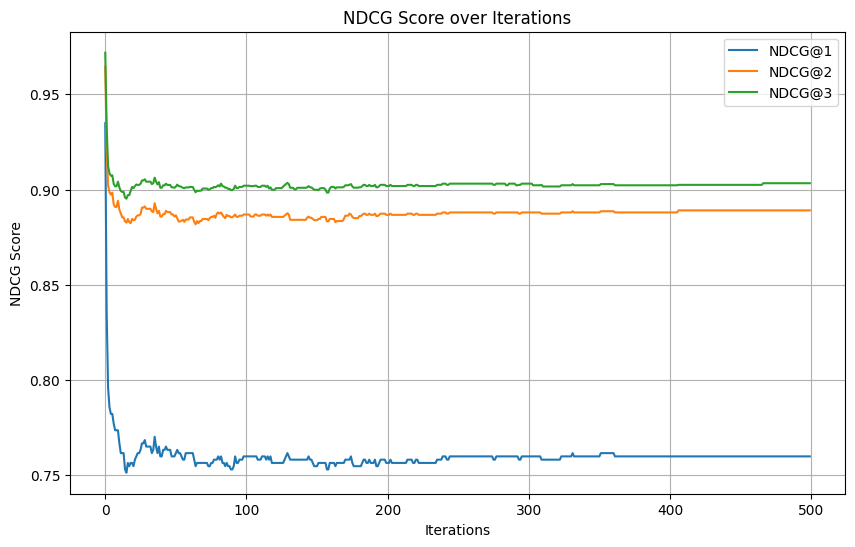

Best NDCG@1: 0.7599 in iteration: 0
Best NDCG@2: 0.8891 in iteration: 0
Best NDCG@3: 0.9033 in iteration: 0


In [47]:
# トレーニング結果の取得
evals_result = lambdarank_model_second.evals_result_

# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evals_result['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evals_result['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@1'][lambdarank_model_second.best_iteration_ - 1], lambdarank_model_second.best_iteration_))
print("Best NDCG@2: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@2'][lambdarank_model_second.best_iteration_ - 1], lambdarank_model_second.best_iteration_))
print("Best NDCG@3: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@3'][lambdarank_model_second.best_iteration_ - 1], lambdarank_model_second.best_iteration_))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8881
[LightGBM] [Info] Number of data points in the train set: 24938, number of used features: 60
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

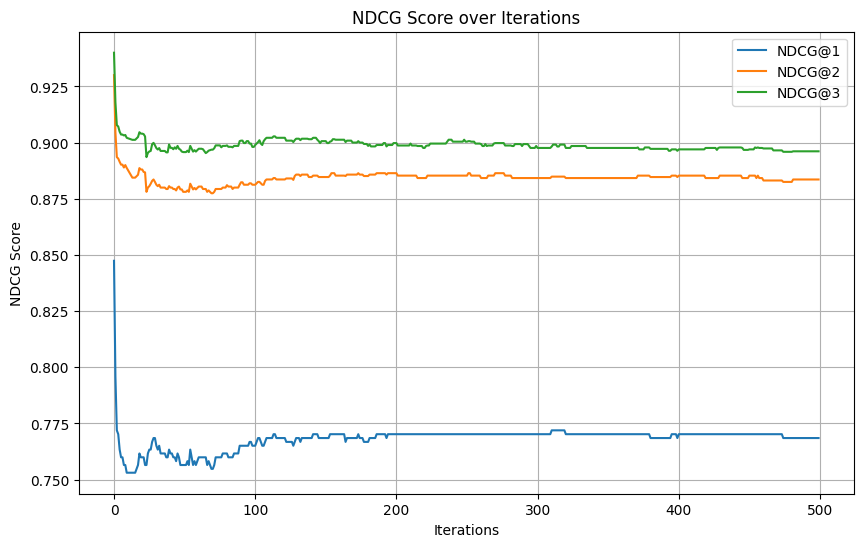

Best NDCG@1: 0.7685 in iteration: 0
Best NDCG@2: 0.8836 in iteration: 0
Best NDCG@3: 0.8961 in iteration: 0


In [48]:
# アンサンブル候補①LightGBM(RankNet)

# LightGBMデータセット
train_data = lgb.Dataset(X_sorted_train_data_copy, label=y_train_ranking, group=train_query)
valid_data = lgb.Dataset(X_sorted_valid_data_copy, label=y_valid_ranking, group=valid_query)
# パラメータの設定
params = {
    'objective': 'rank_xendcg',
    'metric': 'ndcg',
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'ndcg_at': [1, 2, 3],
    'n_estimators':500,              # 決定木の個数(default:100) 5000のほうが10000より高い
    'learning_rate':0.05,            # 学習率(default:0.1)
    'max_depth':8,                  # 決定木の深さの最大値(default:-1)
    "min_data_in_leaf":40,         # 決定木のノードに含まれる最小サンプル数(default:20)
    "lambdarank_truncation_level":1,
}

evaluation_results = {}
# モデルの学習
ranknet_model_second = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[lgb.record_evaluation(evaluation_results)],
)

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evaluation_results['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evaluation_results['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evaluation_results['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(ranknet_model_second.best_score['valid_0']['ndcg@1'], ranknet_model_second.best_iteration))
# 2も出力
print("Best NDCG@2: {:.4f} in iteration: {}".format(ranknet_model_second.best_score['valid_0']['ndcg@2'], ranknet_model_second.best_iteration))
# 3も出力
print("Best NDCG@3: {:.4f} in iteration: {}".format(ranknet_model_second.best_score['valid_0']['ndcg@3'], ranknet_model_second.best_iteration))



[20:41:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "max_position", "min_child_samples" } are not used.

[0]	validation_0-ndcg:0.94421


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-ndcg:0.90013


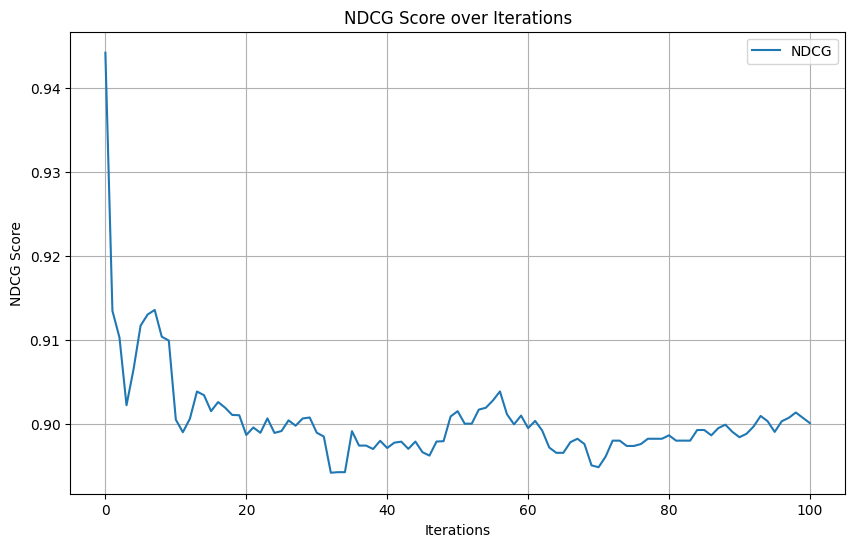

Best NDCG: 0.9442 in iteration: 0


In [49]:
# アンサンブル候補②XGBoost(Pairwise)
from xgboost import XGBRanker
# モデルの定義
pairwise_model_second = XGBRanker(
    objective='rank:pairwise',
    eval_metric='ndcg',
    n_estimators=1000,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    max_depth=10,                    # 決定木の深さの最大値(default:6)
    # subsample=0.8,                  # データのサンプリング比率(default:1)
    # colsample_bytree=0.8,           # 列のサンプリング比率(default:1)
    # min_child_weight=0.5,           # 葉の重みの最小値(default:1)
    # reg_lambda=1.0,                 # L2正則化の強さ(default:1)
    # gamma=0.1,                      # 葉の追加分岐を行うかの閾値(default:0)
    # n_jobs=-1,                      # 並列処理の数(default:1)
    random_state=42,                # 乱数のシード値(default:0)
    max_position=3, # 3位までの順位を予測する
    min_child_samples=30,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # lambdarank_truncation_level=5,
)
# モデルの学習
pairwise_model_second.fit(
    X_sorted_train_data_copy,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data_copy, y_valid_ranking)],
    eval_group=[valid_query],
    verbose=100,
    early_stopping_rounds=100,
)

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(pairwise_model_second.evals_result()['validation_0']['ndcg'], label='NDCG')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG: {:.4f} in iteration: {}".format(pairwise_model_second.best_score, pairwise_model_second.best_iteration))

[LightGBM] [Warning] Unknown parameter: max_position


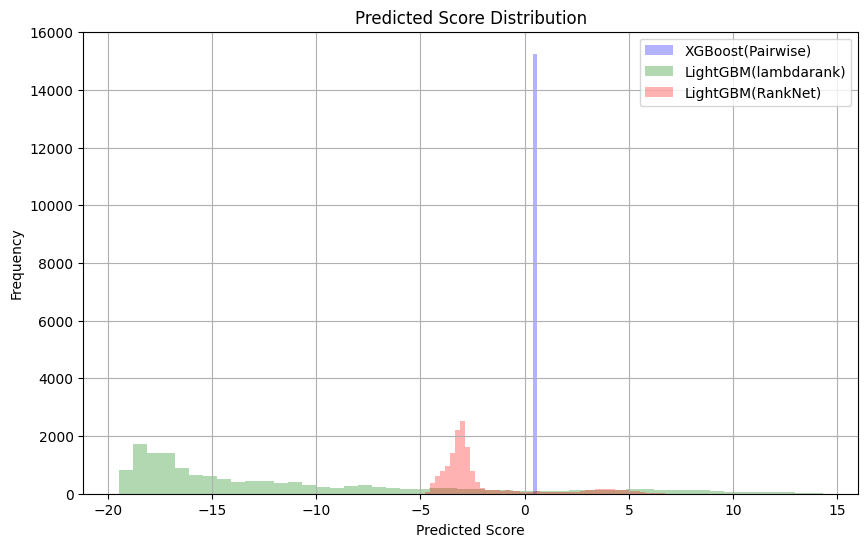

0.45996374


In [50]:
#　テストデータで推論
# LighGBM(lambdarank)の推論
prediction_test_ranking = lambdarank_model_second.predict(test_ranking_copy, num_iteration=lambdarank_model_second.best_iteration_)
# LightGBM(RankNet)の推論
prediction_test_ranking_ranknet = ranknet_model_second.predict(test_ranking_copy)
# XGBoost(Pairwise)の推論
prediction_test_ranking_pairwise = pairwise_model_second.predict(test_ranking_copy)
# 上記の平均をアンサンブルモデルとする
prediction_test_ranking_ensemble = (prediction_test_ranking + prediction_test_ranking_ranknet + prediction_test_ranking_pairwise) / 3

df_prediction_test_ranking = pd.DataFrame({
    "馬番号": test_ranking_copy["umaban"],
    "予測スコア(lambdarank)": prediction_test_ranking,
    "予測スコア(RankNet)": prediction_test_ranking_ranknet,
    "予測スコア(Pairwise)": prediction_test_ranking_pairwise,
    "ensemble_prediction": prediction_test_ranking_ensemble,
    "着順関連度": y_test_true_ranking,
    "着順": y_test_true_ranking_goal,
    "race_id": test_ranking_race_id,
    "distance": test_ranking_copy["distance"],
    "ground_state": test_ranking_copy["ground_state"],
    "weather": test_ranking_copy["weather"],
    "condition": test_ranking_copy["condition"],
})


# 同じレースidのうちスコアの大きい順に1位から予測順位を計算する
def rank_predictions(data, score_column, rank_column):
    data[rank_column] = data.groupby("race_id")[score_column].rank(ascending=False, method='first')
    data[rank_column] = data.groupby("race_id")[rank_column].transform(lambda x: x + 1)
    return data
# 予測順位をつける
df_prediction_test_ranking = rank_predictions(df_prediction_test_ranking, "予測スコア(lambdarank)", "予測順位(lambdarank)")
df_prediction_test_ranking = rank_predictions(df_prediction_test_ranking, "予測スコア(RankNet)", "予測順位(RankNet)")
df_prediction_test_ranking = rank_predictions(df_prediction_test_ranking, "予測スコア(Pairwise)", "予測順位(Pairwise)")
df_prediction_test_ranking = rank_predictions(df_prediction_test_ranking, "ensemble_prediction", "ensemble_prediction_rank")

df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking["予測順位(lambdarank)"].astype(int)
df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking["予測順位(RankNet)"].astype(int)
df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking["予測順位(Pairwise)"].astype(int)
df_prediction_test_ranking["ensemble_prediction_rank"] = df_prediction_test_ranking["ensemble_prediction_rank"].astype(int)

# 3つのモデルがすべて1位と判断したときだけ1位とするアンサンブルモデル
# df_prediction_test_ranking['ensemble_prediction'] = (
#     (df_prediction_test_ranking['予測順位(lambdarank)'] == 1) &
#     (df_prediction_test_ranking['予測順位(RankNet)'] == 1) &
#     (df_prediction_test_ranking['予測順位(Pairwise)'] == 1)
# ).astype(int)

# 予測スコアの分布を可視化
plt.figure(figsize=(10, 6))

# XGBoost(Pairwise)のヒストグラム
plt.hist(prediction_test_ranking_pairwise, bins=1, alpha=0.3, label='XGBoost(Pairwise)', color='blue')

# LightGBM(lambdarank)のヒストグラム
plt.hist(prediction_test_ranking, bins=50, alpha=0.3, label='LightGBM(lambdarank)', color='green')

# LightGBM(RankNet)のヒストグラム
plt.hist(prediction_test_ranking_ranknet, bins=50, alpha=0.3, label='LightGBM(RankNet)', color='red')

plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.title('Predicted Score Distribution')
plt.legend()
plt.grid(True)
plt.show()

# 予測結果を保存
df_prediction_test_ranking.to_csv("prediction_test_secandary_ranking.csv", index=False)
print(prediction_test_ranking_pairwise.mean())



LightGBM(lambdarank)の評価
True Positive: 359
False Positive: 866
False Negative: 863
True Negative: 13172
Precision: 0.2931
Recall: 0.2938
F1 Score: 0.2934


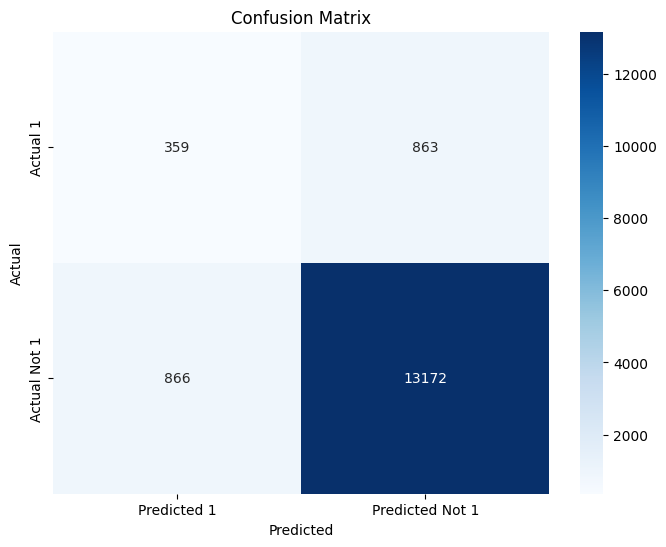

LightGBM(RankNet)の評価
True Positive: 367
False Positive: 858
False Negative: 855
True Negative: 13180
Precision: 0.2996
Recall: 0.3003
F1 Score: 0.3000


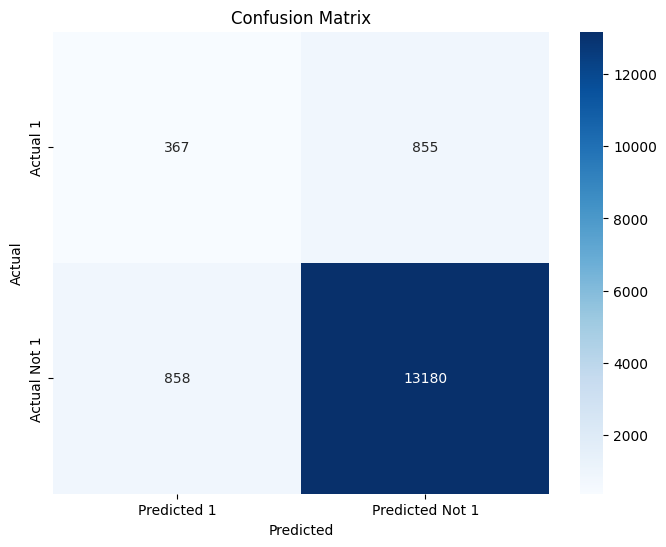

XGBoost(Pairwise)の評価
True Positive: 584
False Positive: 641
False Negative: 638
True Negative: 13397
Precision: 0.4767
Recall: 0.4779
F1 Score: 0.4773


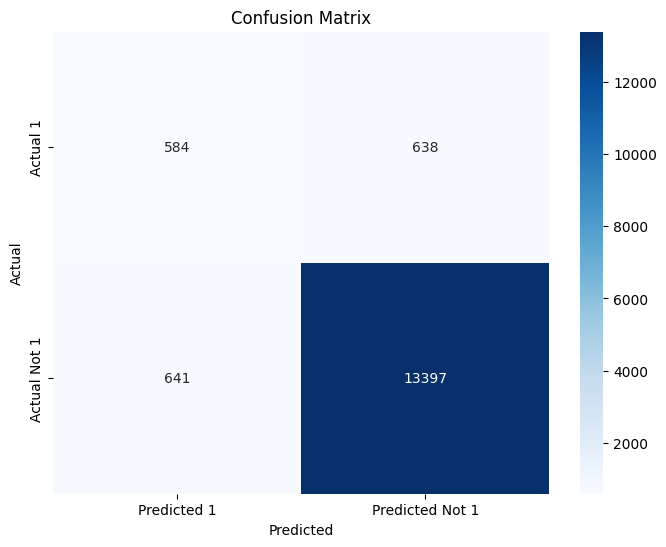

アンサンブルモデルの評価
True Positive: 360
False Positive: 865
False Negative: 862
True Negative: 13173
Precision: 0.2939
Recall: 0.2946
F1 Score: 0.2942


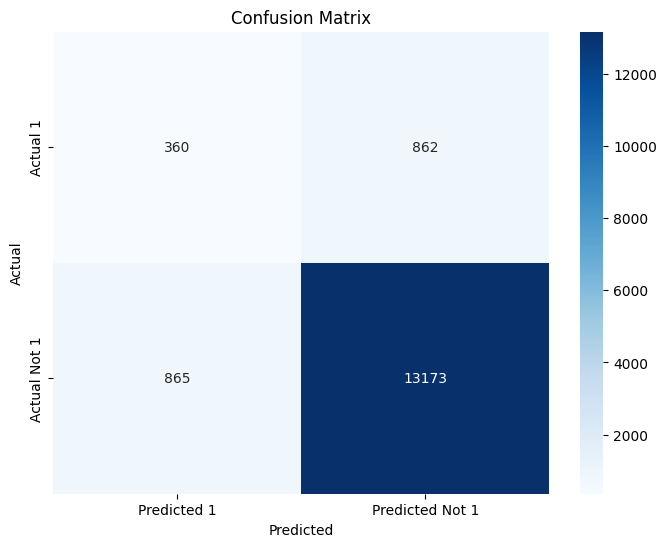

In [51]:
# 2位のスコアにおける予測結果の評価
print("LightGBM(lambdarank)の評価")
rank_evaluation_N(df_prediction_test_ranking, '予測順位(lambdarank)')
print("LightGBM(RankNet)の評価")
rank_evaluation_N(df_prediction_test_ranking, '予測順位(RankNet)')
print("XGBoost(Pairwise)の評価")
rank_evaluation_N(df_prediction_test_ranking, '予測順位(Pairwise)')
print("アンサンブルモデルの評価")
rank_evaluation_N(df_prediction_test_ranking, 'ensemble_prediction_rank')

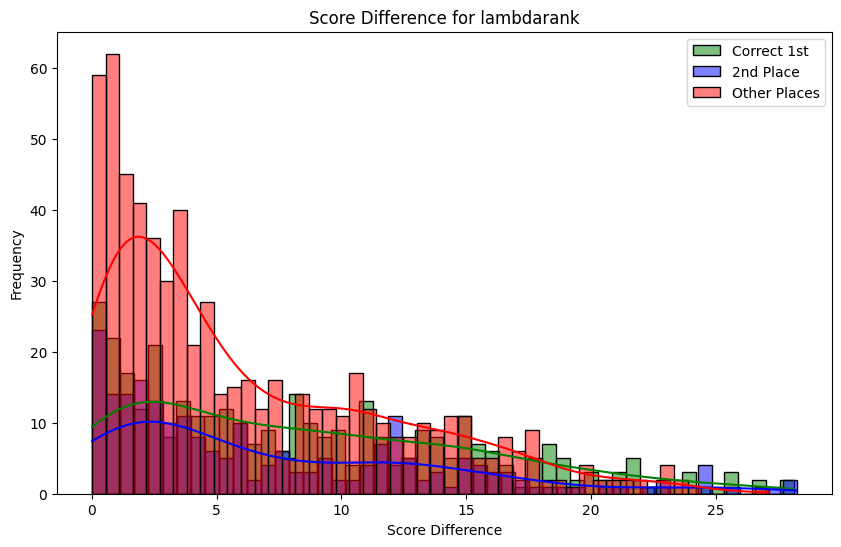

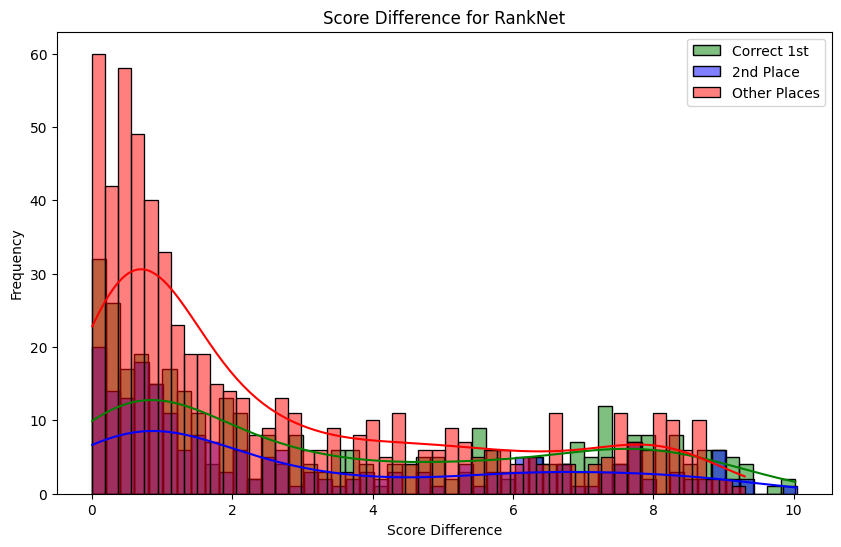

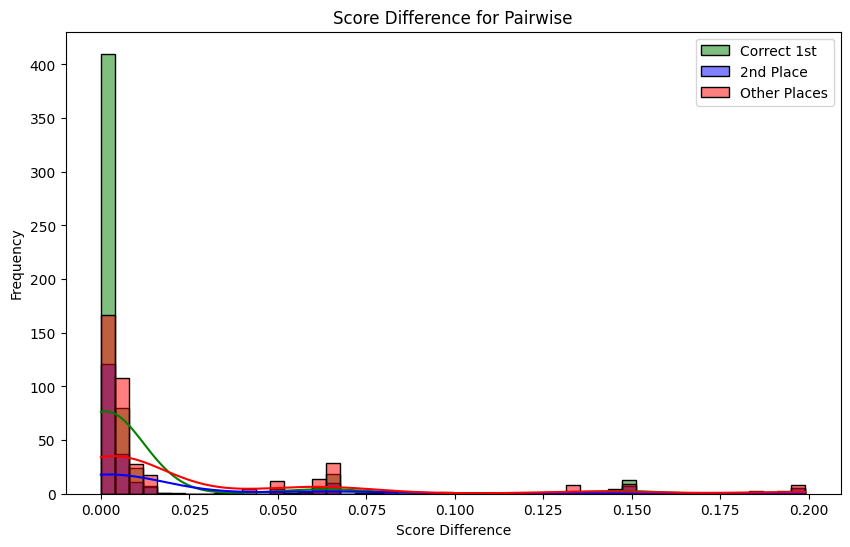

Optimal Threshold (ROC) for lambdarank: 5.294602698345935
Optimal Threshold (Precision-Recall) for lambdarank: 0.020494431503683685
Optimal Threshold (ROC) for RankNet: 2.7381113290601005
Optimal Threshold (Precision-Recall) for RankNet: 0.0074624575142454574
Optimal Threshold (ROC) for Pairwise: 0.005782485008239746
Optimal Threshold (Precision-Recall) for Pairwise: 0.0
LightGBM(lambdarank)の評価
82132     0
82134     0
82135     0
82137     0
82139     0
         ..
115603    0
115605    0
115607    0
115608    0
115610    0
Name: 予測結果(lambdarank), Length: 15260, dtype: int64
True Positive: 213
False Positive: 374
False Negative: 1009
True Negative: 13664
Precision: 0.3629
Recall: 0.1743
F1 Score: 0.2355


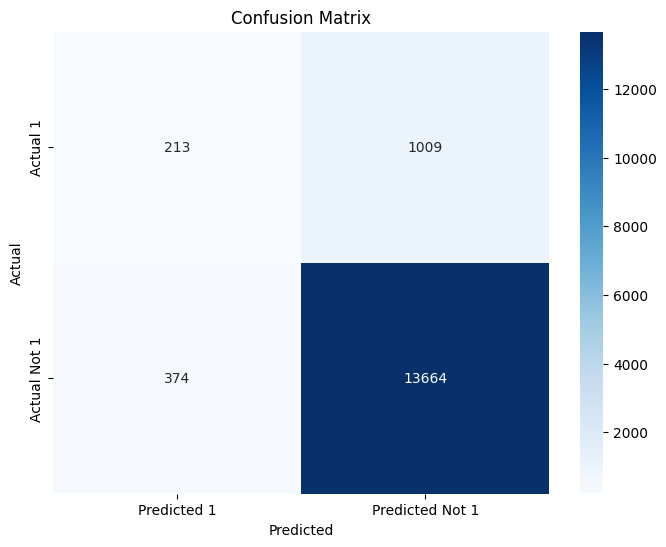

LightGBM(RankNet)の評価
True Positive: 174
False Positive: 312
False Negative: 1048
True Negative: 13726
Precision: 0.3580
Recall: 0.1424
F1 Score: 0.2037


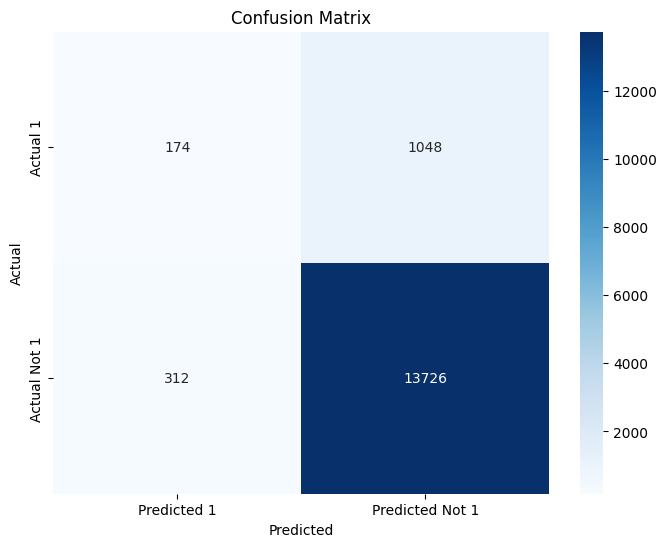

XGBoost(Pairwise)の評価
True Positive: 107
False Positive: 221
False Negative: 1115
True Negative: 13817
Precision: 0.3262
Recall: 0.0876
F1 Score: 0.1381


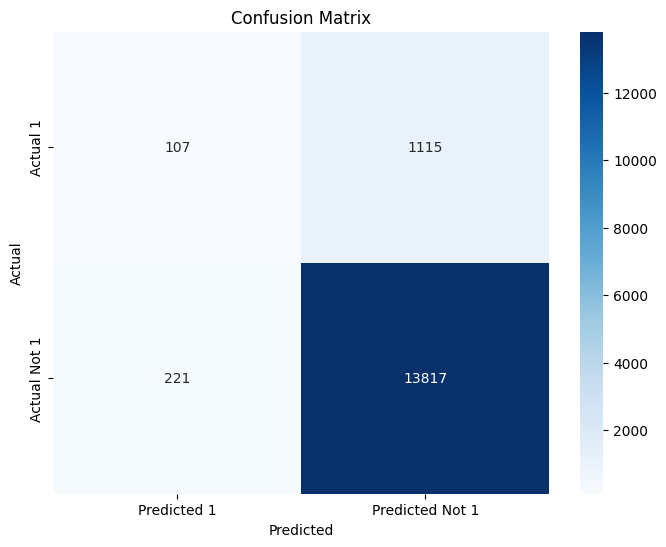

In [52]:
# 同じようなアプローチで2位と3位のスコアの差から2位の予測精度の向上にトライ
# 1位と2位のスコアの差を可視化する→閾値を決定してコンフュージョンマトリックスで正解率を確認する
df_prediction_test_ranking['score_diff_lambdarank'] = calculate_score_diff(df_prediction_test_ranking, 'lambdarank')
df_prediction_test_ranking['score_diff_RankNet'] = calculate_score_diff(df_prediction_test_ranking, 'RankNet')
df_prediction_test_ranking['score_diff_Pairwise'] = calculate_score_diff(df_prediction_test_ranking, 'Pairwise')

plot_score_diff(df_prediction_test_ranking, 'lambdarank', 2)
plot_score_diff(df_prediction_test_ranking, 'RankNet', 2)
plot_score_diff(df_prediction_test_ranking, 'Pairwise', 2)

optimal_threshold_lambdarank, optimal_threshold_pr_lambdarank = find_optimal_threshold(df_prediction_test_ranking, 'lambdarank', 2)
optimal_threshold_ranknet, optimal_threshold_pr_ranknet = find_optimal_threshold(df_prediction_test_ranking, 'RankNet', 2)
optimal_threshold_pairwise, optimal_threshold_pr_pairwise = find_optimal_threshold(df_prediction_test_ranking, 'Pairwise', 2)
print(f'Optimal Threshold (ROC) for lambdarank: {optimal_threshold_lambdarank}')
print(f'Optimal Threshold (Precision-Recall) for lambdarank: {optimal_threshold_pr_lambdarank}')
print(f'Optimal Threshold (ROC) for RankNet: {optimal_threshold_ranknet}')
print(f'Optimal Threshold (Precision-Recall) for RankNet: {optimal_threshold_pr_ranknet}')
print(f'Optimal Threshold (ROC) for Pairwise: {optimal_threshold_pairwise}')
print(f'Optimal Threshold (Precision-Recall) for Pairwise: {optimal_threshold_pr_pairwise}')

df_prediction_test_ranking = apply_threshold_second(df_prediction_test_ranking, 'lambdarank', optimal_threshold_lambdarank)
df_prediction_test_ranking = apply_threshold_second(df_prediction_test_ranking, 'RankNet', optimal_threshold_ranknet)
df_prediction_test_ranking = apply_threshold_second(df_prediction_test_ranking, 'Pairwise', optimal_threshold_pairwise)

print("LightGBM(lambdarank)の評価")
print(df_prediction_test_ranking['予測結果(lambdarank)'])
rank_evaluation_N(df_prediction_test_ranking, '予測結果(lambdarank)')
print("LightGBM(RankNet)の評価")
rank_evaluation_N(df_prediction_test_ranking, '予測結果(RankNet)')
print("XGBoost(Pairwise)の評価")
rank_evaluation_N(df_prediction_test_ranking, '予測結果(Pairwise)')

In [53]:
# 特徴重要度の可視化
df_importance = pd.DataFrame({"columns": X_sorted_train_data_copy.columns, "importance": pairwise_model_second.feature_importances_})
df_importance.sort_values("importance", ascending=False, inplace=True)
print(df_importance)

                             columns  importance
59           pred_score_Pairwise_inv    0.874295
49               score_diff_Pairwise    0.030449
50          top2_score_diff_Pairwise    0.014680
54          top3_mean_score_Pairwise    0.013346
57  second_third_score_diff_Pairwise    0.003064
53      top_mean_score_diff_Pairwise    0.002499
55        below2_mean_score_Pairwise    0.002278
52              score_range_Pairwise    0.001674
29                              騎乗回数    0.001577
58   second_last_score_diff_Pairwise    0.001516
23                   weight_change_y    0.001480
27                                3着    0.001461
56         below2_score_std_Pairwise    0.001446
14                                人気    0.001434
21                                上り    0.001423
38                            peds_3    0.001406
8                       ground_state    0.001380
47                     odds_diff-1-3    0.001351
16                                距離    0.001346
51                sc

In [54]:
from pathlib import Path
import pandas as pd
import tqdm
from utils.utils_inference import *

# 青色で出力
# "RankNetの正答率が高い"
print("\033[34m3つのモデルで1番かつ-1あたり以上ならよさげ\033[0m")
# csvデータを1つずつ読み出し推論
p = Path(inference_data_path)
files = list(p.glob("*inference*.csv"))
print(p)
print(files)
count = 0
for file in tqdm.tqdm(files):
    # 読み込んだファイル名を出力
    # print("=======予測ファイル名======== {}".format(file))
    print("=======予測ファイル名========\n {}".format(file))
    inference_data = pd.read_csv(file, encoding='utf-8')
    # データの確認
    # print(inference_data.info())

    # Unnamed: 0,class_list_in_raceを削除
    # inference_data = inference_data.drop(['Unnamed: 0',"class_list_in_race","date"], axis=1)

    #　=================real dataで推論=============================
    # inference_data, inference_data_odds, inference_data_race_id,inference_data_answer = preprocess_for_inference(inference_data,True)
    # オッズの差分を計算して新しい特徴量として追加
    inference_data = add_odds_differences_for_inference(inference_data)
    
    # 推論済みの特長量"予測スコア(lambdarank)"をpred_score_lambdarankに変更
    inference_data = inference_data.rename(columns={'予測スコア(lambdarank)': 'pred_score_lambdarank'})
    # 推論済みの特長量"予測スコア(RankNet)"をpred_score_RankNetに変更
    inference_data = inference_data.rename(columns={'予測スコア(RankNet)': 'pred_score_RankNet'})
    # 推論済みの特長量"予測スコア(Pairwise)"をpred_score_Pairwiseに変更
    inference_data = inference_data.rename(columns={'予測スコア(Pairwise)': 'pred_score_Pairwise'})
    # テストデータに特長量を追加
    inference_data = add_race_features(inference_data, 'lambdarank', False)
    inference_data = add_race_features(inference_data, 'RankNet', False)
    inference_data = add_race_features(inference_data, 'Pairwise', False)

    # 予測スコア1位の馬を削除
    def remove_top_horse_no_race_id(data, model_name):
        # 最大スコアの馬情報を取得
        max_score = data[f'pred_score_{model_name}'].max()
        
        # 最大スコアの馬情報を削除
        data = data[data[f'pred_score_{model_name}'] != max_score]
        
        return data
    # 推論データから最大スコアの馬情報を削除
    inference_data = remove_top_horse_no_race_id(inference_data, 'lambdarank')
    inference_data = remove_top_horse_no_race_id(inference_data, 'RankNet')
    inference_data = remove_top_horse_no_race_id(inference_data, 'Pairwise')
    inference_data.info()
    inference_data_odds = inference_data["odds"]
    # inference_dataの特長量を設定する
    inference_data = inference_data[X_sorted_train_data_copy.columns]

    # ラベルエンコーディングは前処理終了後
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = inference_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        # print(column)
        le = LabelEncoder()
        # object型は別のラベル名にてラベルエンコーディングする
        inference_data[column] = le.fit_transform(inference_data[column])
    # print(inference_data.info())

    # 対数変換実施
    # inference_data = log_transform(inference_data)

    # 標準化実施
    # inference_data = standard_scaler(inference_data)

    # モデル予測
    prediction_inference_ranking = lambdarank_model_second.predict(inference_data, num_iteration=lambdarank_model_second.best_iteration_)
    prediction_inference_ranking_ranknet = ranknet_model_second.predict(inference_data)
    prediction_inference_ranking_pairwise = pairwise_model_second.predict(inference_data)
    # シンプルに予測結果の平均を取る
    prediction_inference = (prediction_inference_ranking + prediction_inference_ranking_ranknet + prediction_inference_ranking_pairwise) / 3
    # データフレームを作成
    df_prediction_test_ranking = pd.DataFrame({
        "horse_id": inference_data["umaban"],
        "予測スコア(lambdarank)": prediction_inference_ranking,
        "予測スコア(RankNet)": prediction_inference_ranking_ranknet,
        "予測スコア(Pairwise)": prediction_inference_ranking_pairwise,
        "predict_amsamble": prediction_inference,
        "odds": inference_data_odds,
        "distance": inference_data["distance"],
        "condition": inference_data["condition"],
        "weather": inference_data["weather"],
        "ground_state": inference_data["ground_state"],
        "race_id":["test"] * len(inference_data)
    })

    # 同じレースidのうちスコアの大きい順に1位から予測順位を計算する
    def rank_predictions(data, score_column, rank_column):
        data[rank_column] = data[score_column].rank(ascending=False, method='first')
        data[rank_column] = data[rank_column].transform(lambda x: x + 1)
        return data
    # 予測順位をつける
    df_prediction_test_ranking = rank_predictions(df_prediction_test_ranking, "予測スコア(lambdarank)", "予測順位(lambdarank)")
    df_prediction_test_ranking = rank_predictions(df_prediction_test_ranking, "予測スコア(RankNet)", "予測順位(RankNet)")
    df_prediction_test_ranking = rank_predictions(df_prediction_test_ranking, "予測スコア(Pairwise)", "予測順位(Pairwise)")

    df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking["予測順位(lambdarank)"].astype(int)
    df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking["予測順位(RankNet)"].astype(int)
    df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking["予測順位(Pairwise)"].astype(int)

    # インデックスをリセット
    df_prediction_test_ranking = df_prediction_test_ranking.reset_index(drop=True)

    # 結果を確認
    # print(df_prediction_test_ranking.head())
    # pandasをcsvに保存
    # inference_data_path + /inference_resultにディレクトリを作成し、csvを保存する
    inference_data_path_result = inference_data_path + "inference_result/"
    if not os.path.isdir(inference_data_path_result):
        os.mkdir(inference_data_path_result)
    file_name = file.name
    saving_path = inference_data_path_result + "prediction_second" +  str(file_name) + "_.csv"
    # print("saving_path:{}".format(saving_path))
    df_prediction_test_ranking.to_csv(saving_path, index=False)

    # 推論データに対して予測を行う。1位と2位のスコアの差を計算し、閾値を適用して各モデルごとに1位を予測する
    # df_prediction_test_ranking = prediction_print(df_prediction_test_ranking,optimal_threshold_lambdarank,optimal_threshold_ranknet,optimal_threshold_pairwise,2)
    def print_second_place_info(data, score_column, rank_column):
        # 2位のスコアを取得
        second_place = data[data[rank_column] == 2]
        
        if not second_place.empty:
            for index, row in second_place.iterrows():
                umaban = row['horse_id']
                score = row[score_column]
                rank = row[rank_column]
                result = row['result'] if 'result' in row else 'N/A'
                print(f"Umaban: {umaban}, Score: {score}, Rank: {rank}, Result: {result}")
        else:
            print("No second place found.")
    # それぞれの予測結果、スコアを出力
    print("lambdarank")
    # 2位の情報を出力
    print_second_place_info(df_prediction_test_ranking, "予測スコア(lambdarank)", "予測順位(lambdarank)")
    print("RankNet")
    print_second_place_info(df_prediction_test_ranking, "予測スコア(RankNet)", "予測順位(RankNet)")
    print("Pairwise")
    print_second_place_info(df_prediction_test_ranking, "予測スコア(Pairwise)", "予測順位(Pairwise)")
    count +=1


3つのモデルで1番かつ-1あたり以上ならよさげ
/home/hayato/horse_inference/inference/2025060201/add_dynamic_data
[PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602019.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602018.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_202506020110.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602015.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602016.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602011.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602017.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dy

  0%|          | 0/11 [00:00<?, ?it/s]

=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602019.csv
<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 11
Columns: 116 entries, Unnamed: 0 to second_last_score_diff_Pairwise
dtypes: float64(63), int64(25), object(28)
memory usage: 9.1+ KB


KeyError: "['pred_score_Pairwise_inv'] not in index"